# Carga librerias

In [1]:

import pickle
import os
import math

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
import seaborn as sns
import random
import matplotlib.patches as mpatches

from xgboost import XGBRegressor, callback

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn import set_config

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

set_config(transform_output = "pandas")

pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

from datetime import datetime, timedelta
from IPython.display import display
import matplotlib.cm as cm

In [2]:
import xgboost
print('xgboost verision:')
print(xgboost.__version__)

xgboost verision:
2.1.4


# Carga Data set   

In [3]:
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD)

print(CWD)
print(DATA_PATH)
print(os.listdir(DATA_PATH))

c:\Users\gaspi\Desktop\TFM--DSMarket
c:\Users\gaspi\Desktop\TFM--DSMarket
['.git', '.gitignore', 'daily_calendar_with_events.csv', 'df_sales_wprice.csv', 'df_sales_wprice.pkl', 'df_wcluster_all_k7.pkl', 'df_wprediction.pkl', 'DsMarket - Clustering_productos.ipynb', 'DsMarket - Clustering_stores.ipynb', 'DsMarket - Forecast - cluster.ipynb', 'DSMarket - forecast graficos.ipynb', 'DsMarket - Limpieza de datos.ipynb', 'DsMarket.pbix', 'Forecast old', 'item_prices.csv', 'item_sales.csv', 'test_results.pkl']


In [4]:
df = pd.read_pickle(DATA_PATH + "/df_wcluster_all_k7.pkl")

# EDA

In [5]:
def report_df(df, verbose=True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    display(df.info(verbose=verbose))  # Mostrar info sin truncar

    total_nulos = df.isnull().sum().sum()
    print(f"\nTenemos un total de {total_nulos} valores nulos.\n")

    print("Cantidad de valores únicos por columna:")
    display(df.nunique())  # Mostrar como tabla sin truncar

In [6]:
df

item     category     department              store  \
0          ACCESORIES_1_001   ACCESORIES   ACCESORIES_1  Greenwich_Village   
1          ACCESORIES_1_002   ACCESORIES   ACCESORIES_1  Greenwich_Village   
2          ACCESORIES_1_003   ACCESORIES   ACCESORIES_1  Greenwich_Village   
3          ACCESORIES_1_004   ACCESORIES   ACCESORIES_1  Greenwich_Village   
4          ACCESORIES_1_005   ACCESORIES   ACCESORIES_1  Greenwich_Village   
...                     ...          ...            ...                ...   
58327365  SUPERMARKET_3_823  SUPERMARKET  SUPERMARKET_3      Queen_Village   
58327366  SUPERMARKET_3_824  SUPERMARKET  SUPERMARKET_3      Queen_Village   
58327367  SUPERMARKET_3_825  SUPERMARKET  SUPERMARKET_3      Queen_Village   
58327368  SUPERMARKET_3_826  SUPERMARKET  SUPERMARKET_3      Queen_Village   
58327369  SUPERMARKET_3_827  SUPERMARKET  SUPERMARKET_3      Queen_Village   

                  city  Qsale       date yearweek     event  weekday  \
0             New York      0 2011-01-29   201105  No_event        6   
1             New York      0 2011-01-29   201105  No_event        6   
2             New York      0 2011-01-29   201105  No_event        6   
3             New York      0 2011-01-29   201105  No_event        6   
4             New York      0 2011-01-29   201105  No_event        6   
...                ...    ...        ...      ...       ...      ...   
58327365  Philadelphia      1 2016-04-24   201617  No_event        7   
58327366  Philadelphia      0 2016-04-24   201617  No_event        7   
58327367  Philadelphia      0 2016-04-24   201617  No_event        7   
58327368  Philadelphia      3 2016-04-24   201617  No_event        7   
58327369  Philadelphia      0 2016-04-24   201617  No_event        7   

          unit_price  total_venta  cluster  
0            12.7414        0.000        5  
1             5.2801        0.000        6  
2             3.9501        0.000        6  
3             5.7722        0.000        4  
4             3.9634        0.000        6  
...              ...          ...      ...  
58327365      3.5760        3.576        2  
58327366      2.9760        0.000        2  
58327367      4.7760        0.000        5  
58327368      1.5360        4.608        2  
58327369      1.2000        0.000        5  

[58327370 rows x 13 columns]

Creamos un nuevo df con yearweek y el primer dia de esa semana para las fechas de laserie temporal

In [7]:
df_yearweek_day = df.groupby('yearweek', as_index=False)['date'].min()

In [8]:
df_days_per_week = df.groupby("yearweek")["date"].nunique().reset_index()
df_days_per_week.columns = ["yearweek", "days_count"]

# Filtrar los yearweeks con menos de 7 días
df_incomplete_weeks = df_days_per_week[df_days_per_week["days_count"] < 7]

In [9]:
df_incomplete_weeks

yearweek  days_count
273   201617           2

In [10]:
df.drop(columns="yearweek",inplace=True)

Eliminaremos la columna yearweek ya que no esta completa y crearemos una nueva para que tenga 7 dias la ultima semana y sea de lunes a domingo 

In [11]:
df['year'] = df['date'].dt.isocalendar().year
df['week'] = df['date'].dt.isocalendar().week

# Crear columna yearweek en formato numérico (ej: 201617)
df['yearweek'] = df['year'] * 100 + df['week']

In [12]:
df_days_per_week = df.groupby("yearweek")["date"].nunique().reset_index()
df_days_per_week.columns = ["yearweek", "days_count"]

# Filtrar los yearweeks con menos de 7 días
df_incomplete_weeks = df_days_per_week[df_days_per_week["days_count"] < 7]

In [13]:
df_incomplete_weeks

yearweek  days_count
0    201104           2

Eliminamos la primer semana ya que no esta completa

In [14]:
df = df[df['yearweek'] != 201104]

In [15]:
df = df.reset_index(drop=True)

In [16]:
df

item     category     department              store  \
0          ACCESORIES_1_001   ACCESORIES   ACCESORIES_1  Greenwich_Village   
1          ACCESORIES_1_002   ACCESORIES   ACCESORIES_1  Greenwich_Village   
2          ACCESORIES_1_003   ACCESORIES   ACCESORIES_1  Greenwich_Village   
3          ACCESORIES_1_004   ACCESORIES   ACCESORIES_1  Greenwich_Village   
4          ACCESORIES_1_005   ACCESORIES   ACCESORIES_1  Greenwich_Village   
...                     ...          ...            ...                ...   
58266385  SUPERMARKET_3_823  SUPERMARKET  SUPERMARKET_3      Queen_Village   
58266386  SUPERMARKET_3_824  SUPERMARKET  SUPERMARKET_3      Queen_Village   
58266387  SUPERMARKET_3_825  SUPERMARKET  SUPERMARKET_3      Queen_Village   
58266388  SUPERMARKET_3_826  SUPERMARKET  SUPERMARKET_3      Queen_Village   
58266389  SUPERMARKET_3_827  SUPERMARKET  SUPERMARKET_3      Queen_Village   

                  city  Qsale       date     event  weekday  unit_price  \
0             New York      0 2011-01-31  No_event        1     12.7414   
1             New York      0 2011-01-31  No_event        1      5.2801   
2             New York      0 2011-01-31  No_event        1      3.9501   
3             New York      0 2011-01-31  No_event        1      5.7722   
4             New York      0 2011-01-31  No_event        1      3.9634   
...                ...    ...        ...       ...      ...         ...   
58266385  Philadelphia      1 2016-04-24  No_event        7      3.5760   
58266386  Philadelphia      0 2016-04-24  No_event        7      2.9760   
58266387  Philadelphia      0 2016-04-24  No_event        7      4.7760   
58266388  Philadelphia      3 2016-04-24  No_event        7      1.5360   
58266389  Philadelphia      0 2016-04-24  No_event        7      1.2000   

          total_venta  cluster  year  week  yearweek  
0               0.000        5  2011     5    201105  
1               0.000        6  2011     5    201105  
2               0.000        6  2011     5    201105  
3               0.000        4  2011     5    201105  
4               0.000        6  2011     5    201105  
...               ...      ...   ...   ...       ...  
58266385        3.576        2  2016    16    201616  
58266386        0.000        2  2016    16    201616  
58266387        0.000        5  2016    16    201616  
58266388        4.608        2  2016    16    201616  
58266389        0.000        5  2016    16    201616  

[58266390 rows x 15 columns]

In [17]:
report_df(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58266390 entries, 0 to 58266389
Data columns (total 15 columns):
 #   Column       Dtype         
---  ------       -----         
 0   item         object        
 1   category     object        
 2   department   object        
 3   store        object        
 4   city         object        
 5   Qsale        int64         
 6   date         datetime64[ns]
 7   event        object        
 8   weekday      int64         
 9   unit_price   float64       
 10  total_venta  float64       
 11  cluster      int32         
 12  year         UInt32        
 13  week         UInt32        
 14  yearweek     UInt32        
dtypes: UInt32(3), datetime64[ns](1), float64(2), int32(1), int64(2), object(6)
memory usage: 5.8+ GB


None


Tenemos un total de 0 valores nulos.

Cantidad de valores únicos por columna:


item            3049
category           3
department         7
store             10
city               3
Qsale            417
date            1911
event              8
weekday            7
unit_price      1859
total_venta    16924
cluster            7
year               6
week              53
yearweek         273
dtype: int64

Revisamos que todos los productos se sigan vendiendo luego del 2015 - Se obvserva que no hay items discontinuos, solo se han agregado nuevos 

In [18]:
# Filtrar solo las ventas reales (Qsale > 0)
df_sold = df[df['Qsale'] > 0]

In [19]:
# Filtrar ventas antes y despues de 2015
df_post_2015 = df_sold[df_sold['yearweek'].astype(str).str[:4].astype(int) >= 2015]
df_pre_2015 = df_sold[df_sold['yearweek'].astype(str).str[:4].astype(int) < 2015]


In [20]:
# Obtener los ítems únicos vendidos antes y despues de 2015
items_sold_post_2015 = set(df_post_2015['item'].unique())
items_sold_pre_2015 = set(df_pre_2015['item'].unique())

In [21]:
items_not_sold_after_2015 = items_sold_pre_2015 - items_sold_post_2015
print("Ítems que dejaron de venderse después de 2015:", items_not_sold_after_2015)

Ítems que dejaron de venderse después de 2015: set()


In [22]:
new_items_post_2015 = items_sold_post_2015 - items_sold_pre_2015
print("Ítems nuevos que comenzaron a venderse después de 2015:", new_items_post_2015)

Ítems nuevos que comenzaron a venderse después de 2015: {'SUPERMARKET_3_500', 'HOME_&_GARDEN_1_308', 'HOME_&_GARDEN_1_246', 'HOME_&_GARDEN_1_242', 'SUPERMARKET_2_185', 'SUPERMARKET_3_254', 'HOME_&_GARDEN_1_534', 'HOME_&_GARDEN_1_484', 'SUPERMARKET_3_466', 'HOME_&_GARDEN_1_201', 'ACCESORIES_1_125', 'HOME_&_GARDEN_1_159', 'HOME_&_GARDEN_2_057', 'SUPERMARKET_3_563', 'HOME_&_GARDEN_1_526', 'ACCESORIES_1_344', 'HOME_&_GARDEN_2_418', 'SUPERMARKET_3_278', 'SUPERMARKET_3_003', 'SUPERMARKET_2_390', 'SUPERMARKET_3_647', 'HOME_&_GARDEN_1_489', 'SUPERMARKET_3_038', 'HOME_&_GARDEN_2_186', 'SUPERMARKET_3_353', 'SUPERMARKET_3_166', 'SUPERMARKET_3_047', 'SUPERMARKET_3_119', 'SUPERMARKET_3_472', 'SUPERMARKET_3_366', 'ACCESORIES_1_232'}


# Preprocesado de datos

Creamos df con los items y clusters

In [23]:
df_clusters = df[['item', 'cluster']].drop_duplicates()

In [24]:
df['Qsale'].sum()

65631029

In [25]:
df = df.drop(columns=['date'])  # Eliminar la columna date

In [26]:
df['Qsale'].sum()

65631029

Agrupamos las ventas por semanas, ya que nuestro forecast sera semanal

In [27]:
# Agrupar por las claves relevantes y sumar las ventas
df_grouped = df.groupby(['yearweek', 'store', 'city', 'category', 'department', 'item', 'event'], as_index=False).agg({
    'Qsale': 'sum',
    'total_venta': 'sum'
})

In [28]:
# Convertir a valores booleanos para determinar si hay eventos
df['has_event'] = df['event'] != 'No_event'

# Agrupar las ventas por semana y consolidar los eventos
df_grouped = df.groupby(['yearweek', 'store', 'city', 'category', 'department', 'item'], as_index=False).agg({
    'Qsale': 'sum',
    'total_venta': 'sum',
    'has_event': 'max'  # Si alguna fila tiene un evento, será True
})

# Convertir el booleano a 'Event' o 'No_event'
df_grouped['event'] = df_grouped['has_event'].map({True: 'Event', False: 'No_event'})

# Eliminar la columna auxiliar
df_grouped.drop(columns=['has_event'], inplace=True)


In [29]:
# Eliminar duplicados generados por la consolidación de eventos
df_grouped = df_grouped.drop_duplicates()

In [30]:
df_grouped["Qsale"].sum()

65631029

Agregamos nuevamente el Sell_price haciendo el precio promedio = Reveune(Total_venta) / la cantidad vendida

In [31]:
df_grouped['sell_price'] = df_grouped["total_venta"]/df_grouped["Qsale"]

In [32]:
df_grouped['sell_price'].fillna(0, inplace=True)

C:\Users\gaspi\AppData\Local\Temp\ipykernel_14988\2313685844.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_grouped['sell_price'].fillna(0, inplace=True)


In [33]:
df_grouped

yearweek     store          city     category     department  \
0          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
1          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
2          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
3          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
4          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
...           ...       ...           ...          ...            ...   
8323765    201616  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8323766    201616  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8323767    201616  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8323768    201616  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8323769    201616  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   

                      item  Qsale  total_venta     event  sell_price  
0         ACCESORIES_1_001      0        0.000     Event       0.000  
1         ACCESORIES_1_002      0        0.000     Event       0.000  
2         ACCESORIES_1_003      0        0.000     Event       0.000  
3         ACCESORIES_1_004      0        0.000     Event       0.000  
4         ACCESORIES_1_005      0        0.000     Event       0.000  
...                    ...    ...          ...       ...         ...  
8323765  SUPERMARKET_3_823      1        3.576  No_event       3.576  
8323766  SUPERMARKET_3_824      3        8.928  No_event       2.976  
8323767  SUPERMARKET_3_825     14       66.864  No_event       4.776  
8323768  SUPERMARKET_3_826     10       15.360  No_event       1.536  
8323769  SUPERMARKET_3_827     12       14.400  No_event       1.200  

[8323770 rows x 10 columns]

Creamos las 4 nuevas semanas para todas las combinaciones ya existentes con valores NAN en Qsale y total venta

In [34]:
df_grouped['yearweek'] = df_grouped['yearweek'].astype(int)

# Obtener combinaciones únicas de store, item y city junto con category y department
unique_combinations = df_grouped[['store', 'item', 'city', 'category', 'department']].drop_duplicates()

# Generar las 4 semanas siguientes para cada combinación
weeks_ahead = 4
expanded_weeks = []
max_week = df_grouped['yearweek'].max()  # Última semana en los datos

for i in range(1, weeks_ahead + 1):
    temp_df = unique_combinations.copy()
    temp_df['yearweek'] = max_week + i  # Agregar semanas futuras
    temp_df['Qsale'] = np.nan
    temp_df['total_venta'] = np.nan
    temp_df['event'] = 'No_event'
    expanded_weeks.append(temp_df)

# Concatenar todo en un nuevo DataFrame
df_future = pd.concat(expanded_weeks, ignore_index=True)

# Unir con el df_grouped original para mantener todo junto
df_final = pd.concat([df_grouped, df_future], ignore_index=True)


In [35]:
df_final["yearweek"].max()

201620

In [36]:
df_final['Qsale'].sum()

65631029.0

In [37]:
df["yearweek"].max()

201616

Se verifica que tenemos 4 semanas mas en el df_final vs el df inicial

In [38]:
# Crear un diccionario {item: cluster}
cluster_dict = df_clusters.set_index('item')['cluster'].to_dict()

# Asignar la columna
df_final['cluster'] = df_final['item'].map(cluster_dict)

In [39]:
df_final

yearweek     store          city     category     department  \
0          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
1          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
2          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
3          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
4          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
...           ...       ...           ...          ...            ...   
8445725    201620  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8445726    201620  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8445727    201620  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8445728    201620  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8445729    201620  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   

                      item  Qsale  total_venta     event  sell_price  cluster  
0         ACCESORIES_1_001    0.0          0.0     Event         0.0        5  
1         ACCESORIES_1_002    0.0          0.0     Event         0.0        6  
2         ACCESORIES_1_003    0.0          0.0     Event         0.0        6  
3         ACCESORIES_1_004    0.0          0.0     Event         0.0        4  
4         ACCESORIES_1_005    0.0          0.0     Event         0.0        6  
...                    ...    ...          ...       ...         ...      ...  
8445725  SUPERMARKET_3_823    NaN          NaN  No_event         NaN        2  
8445726  SUPERMARKET_3_824    NaN          NaN  No_event         NaN        2  
8445727  SUPERMARKET_3_825    NaN          NaN  No_event         NaN        5  
8445728  SUPERMARKET_3_826    NaN          NaN  No_event         NaN        2  
8445729  SUPERMARKET_3_827    NaN          NaN  No_event         NaN        5  

[8445730 rows x 11 columns]

Separamos Year week en dos nuevas columnas

In [40]:
df_final['year'] = df_final['yearweek'] // 100
df_final['week'] = df_final['yearweek'] % 100

Creamos la coluna de mes y trimestre

In [41]:
df_final['date'] = pd.to_datetime(df_final['year'].astype(str) + df_final['week'].astype(str) + '1', format='%Y%W%w')

# Extraer mes y trimestre
df_final['month'] = df_final['date'].dt.month
df_final['quarter'] = df_final['date'].dt.quarter

df_final.drop(columns='date',inplace=True)

In [42]:
df_final

yearweek     store          city     category     department  \
0          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
1          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
2          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
3          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
4          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
...           ...       ...           ...          ...            ...   
8445725    201620  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8445726    201620  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8445727    201620  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8445728    201620  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8445729    201620  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   

                      item  Qsale  total_venta     event  sell_price  cluster  \
0         ACCESORIES_1_001    0.0          0.0     Event         0.0        5   
1         ACCESORIES_1_002    0.0          0.0     Event         0.0        6   
2         ACCESORIES_1_003    0.0          0.0     Event         0.0        6   
3         ACCESORIES_1_004    0.0          0.0     Event         0.0        4   
4         ACCESORIES_1_005    0.0          0.0     Event         0.0        6   
...                    ...    ...          ...       ...         ...      ...   
8445725  SUPERMARKET_3_823    NaN          NaN  No_event         NaN        2   
8445726  SUPERMARKET_3_824    NaN          NaN  No_event         NaN        2   
8445727  SUPERMARKET_3_825    NaN          NaN  No_event         NaN        5   
8445728  SUPERMARKET_3_826    NaN          NaN  No_event         NaN        2   
8445729  SUPERMARKET_3_827    NaN          NaN  No_event         NaN        5   

         year  week  month  quarter  
0        2011     5      1        1  
1        2011     5      1        1  
2        2011     5      1        1  
3        2011     5      1        1  
4        2011     5      1        1  
...       ...   ...    ...      ...  
8445725  2016    20      5        2  
8445726  2016    20      5        2  
8445727  2016    20      5        2  
8445728  2016    20      5        2  
8445729  2016    20      5        2  

[8445730 rows x 15 columns]

Rellenamos los valores de sell price con el valor mas cercano distinto de 0

In [43]:
df_final.loc[df_final['sell_price'] == 0, 'sell_price'] = np.nan

# Rellenar los valores NaN con el valor más cercano dentro del mismo 'store' y 'item'
df_final['sell_price'] = df_final.groupby(['store', 'item'])['sell_price'].transform(lambda x: x.ffill().bfill())

Actualizamos la columna event para que sea flag, y tenga 1 si hay evento

In [44]:
df_final['event'] = df_final['event'].replace({'No_event': 0, 'Event': 1})

C:\Users\gaspi\AppData\Local\Temp\ipykernel_14988\1058968178.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_final['event'] = df_final['event'].replace({'No_event': 0, 'Event': 1})


In [45]:
df_final.dtypes

yearweek         int64
store           object
city            object
category        object
department      object
item            object
Qsale          float64
total_venta    float64
event            int64
sell_price     float64
cluster          int64
year             int64
week             int64
month            int32
quarter          int32
dtype: object

Pasamos las columnas que son objects a numeros

In [46]:
df_final['id'] = df_final['item']+"_"+df_final['store']

In [47]:
df_final

yearweek     store          city     category     department  \
0          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
1          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
2          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
3          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
4          201105  Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
...           ...       ...           ...          ...            ...   
8445725    201620  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8445726    201620  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8445727    201620  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8445728    201620  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8445729    201620  Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   

                      item  Qsale  total_venta  event  sell_price  cluster  \
0         ACCESORIES_1_001    0.0          0.0      1     11.4646        5   
1         ACCESORIES_1_002    0.0          0.0      1      5.2801        6   
2         ACCESORIES_1_003    0.0          0.0      1      3.9501        6   
3         ACCESORIES_1_004    0.0          0.0      1      5.0141        4   
4         ACCESORIES_1_005    0.0          0.0      1      3.9634        6   
...                    ...    ...          ...    ...         ...      ...   
8445725  SUPERMARKET_3_823    NaN          NaN      0      3.5760        2   
8445726  SUPERMARKET_3_824    NaN          NaN      0      2.9760        2   
8445727  SUPERMARKET_3_825    NaN          NaN      0      4.7760        5   
8445728  SUPERMARKET_3_826    NaN          NaN      0      1.5360        2   
8445729  SUPERMARKET_3_827    NaN          NaN      0      1.2000        5   

         year  week  month  quarter                          id  
0        2011     5      1        1   ACCESORIES_1_001_Back_Bay  
1        2011     5      1        1   ACCESORIES_1_002_Back_Bay  
2        2011     5      1        1   ACCESORIES_1_003_Back_Bay  
3        2011     5      1        1   ACCESORIES_1_004_Back_Bay  
4        2011     5      1        1   ACCESORIES_1_005_Back_Bay  
...       ...   ...    ...      ...                         ...  
8445725  2016    20      5        2  SUPERMARKET_3_823_Yorktown  
8445726  2016    20      5        2  SUPERMARKET_3_824_Yorktown  
8445727  2016    20      5        2  SUPERMARKET_3_825_Yorktown  
8445728  2016    20      5        2  SUPERMARKET_3_826_Yorktown  
8445729  2016    20      5        2  SUPERMARKET_3_827_Yorktown  

[8445730 rows x 16 columns]

In [48]:
report_df(df_final)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8445730 entries, 0 to 8445729
Data columns (total 16 columns):
 #   Column       Dtype  
---  ------       -----  
 0   yearweek     int64  
 1   store        object 
 2   city         object 
 3   category     object 
 4   department   object 
 5   item         object 
 6   Qsale        float64
 7   total_venta  float64
 8   event        int64  
 9   sell_price   float64
 10  cluster      int64  
 11  year         int64  
 12  week         int64  
 13  month        int32  
 14  quarter      int32  
 15  id           object 
dtypes: float64(3), int32(2), int64(5), object(6)
memory usage: 966.5+ MB


None


Tenemos un total de 243920 valores nulos.

Cantidad de valores únicos por columna:


yearweek         277
store             10
city               3
category           3
department         7
item            3049
Qsale           1092
total_venta    57213
event              2
sell_price     19979
cluster            7
year               6
week              53
month             12
quarter            4
id             30490
dtype: int64

In [49]:
categorical_cols = ["store", "city", "category", "department", "item"]

In [50]:
encoder = OrdinalEncoder()
df_final_encoded = df_final.copy()  # Crear una copia del DataFrame original
df_final_encoded[categorical_cols] = encoder.fit_transform(df_final[categorical_cols])

Le sumo 1 a las columnas a las que aplicamos el ordinal encoder para que no haya 0

In [51]:
df_final_encoded[categorical_cols] = df_final_encoded[categorical_cols] + 1

In [52]:
mappings = {}
for i, col in enumerate(categorical_cols):
    mappings[col] = dict(enumerate(encoder.categories_[i]))  # Obtener la correspondencia original-numérico

df_mappings = pd.DataFrame.from_dict(mappings, orient='index').transpose() 

Guardamos el ordinal encoding para saber a que numero corresponde cada valor se le agrega 1 para que coincida con el df_final_encoded

In [53]:
df_mappings.index = df_mappings.index + 1

In [54]:
df_mappings

store          city       category       department  \
1              Back_Bay        Boston     ACCESORIES     ACCESORIES_1   
2              Brooklyn      New York  HOME_&_GARDEN     ACCESORIES_2   
3     Greenwich_Village  Philadelphia    SUPERMARKET  HOME_&_GARDEN_1   
4                Harlem           NaN            NaN  HOME_&_GARDEN_2   
5       Midtown_Village           NaN            NaN    SUPERMARKET_1   
...                 ...           ...            ...              ...   
3045                NaN           NaN            NaN              NaN   
3046                NaN           NaN            NaN              NaN   
3047                NaN           NaN            NaN              NaN   
3048                NaN           NaN            NaN              NaN   
3049                NaN           NaN            NaN              NaN   

                   item  
1      ACCESORIES_1_001  
2      ACCESORIES_1_002  
3      ACCESORIES_1_003  
4      ACCESORIES_1_004  
5      ACCESORIES_1_005  
...                 ...  
3045  SUPERMARKET_3_823  
3046  SUPERMARKET_3_824  
3047  SUPERMARKET_3_825  
3048  SUPERMARKET_3_826  
3049  SUPERMARKET_3_827  

[3049 rows x 5 columns]

In [55]:
df_final_encoded = df_final_encoded.sort_index()

In [56]:
df_final_encoded

yearweek  store  city  category  department    item  Qsale  \
0          201105    1.0   1.0       1.0         1.0     1.0    0.0   
1          201105    1.0   1.0       1.0         1.0     2.0    0.0   
2          201105    1.0   1.0       1.0         1.0     3.0    0.0   
3          201105    1.0   1.0       1.0         1.0     4.0    0.0   
4          201105    1.0   1.0       1.0         1.0     5.0    0.0   
...           ...    ...   ...       ...         ...     ...    ...   
8445725    201620   10.0   3.0       3.0         7.0  3045.0    NaN   
8445726    201620   10.0   3.0       3.0         7.0  3046.0    NaN   
8445727    201620   10.0   3.0       3.0         7.0  3047.0    NaN   
8445728    201620   10.0   3.0       3.0         7.0  3048.0    NaN   
8445729    201620   10.0   3.0       3.0         7.0  3049.0    NaN   

         total_venta  event  sell_price  cluster  year  week  month  quarter  \
0                0.0      1     11.4646        5  2011     5      1        1   
1                0.0      1      5.2801        6  2011     5      1        1   
2                0.0      1      3.9501        6  2011     5      1        1   
3                0.0      1      5.0141        4  2011     5      1        1   
4                0.0      1      3.9634        6  2011     5      1        1   
...              ...    ...         ...      ...   ...   ...    ...      ...   
8445725          NaN      0      3.5760        2  2016    20      5        2   
8445726          NaN      0      2.9760        2  2016    20      5        2   
8445727          NaN      0      4.7760        5  2016    20      5        2   
8445728          NaN      0      1.5360        2  2016    20      5        2   
8445729          NaN      0      1.2000        5  2016    20      5        2   

                                 id  
0         ACCESORIES_1_001_Back_Bay  
1         ACCESORIES_1_002_Back_Bay  
2         ACCESORIES_1_003_Back_Bay  
3         ACCESORIES_1_004_Back_Bay  
4         ACCESORIES_1_005_Back_Bay  
...                             ...  
8445725  SUPERMARKET_3_823_Yorktown  
8445726  SUPERMARKET_3_824_Yorktown  
8445727  SUPERMARKET_3_825_Yorktown  
8445728  SUPERMARKET_3_826_Yorktown  
8445729  SUPERMARKET_3_827_Yorktown  

[8445730 rows x 16 columns]

Rellenamos los NAN de Qsale y Total venta con 0, que son las nuevas lineas que agregamos para el forecast

In [57]:
df_final_encoded.isnull().sum()

yearweek            0
store               0
city                0
category            0
department          0
item                0
Qsale          121960
total_venta    121960
event               0
sell_price          0
cluster             0
year                0
week                0
month               0
quarter             0
id                  0
dtype: int64

In [58]:
df_final_encoded = df_final_encoded.fillna(0)

In [59]:
report_df(df_final_encoded)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8445730 entries, 0 to 8445729
Data columns (total 16 columns):
 #   Column       Dtype  
---  ------       -----  
 0   yearweek     int64  
 1   store        float64
 2   city         float64
 3   category     float64
 4   department   float64
 5   item         float64
 6   Qsale        float64
 7   total_venta  float64
 8   event        int64  
 9   sell_price   float64
 10  cluster      int64  
 11  year         int64  
 12  week         int64  
 13  month        int32  
 14  quarter      int32  
 15  id           object 
dtypes: float64(8), int32(2), int64(5), object(1)
memory usage: 966.5+ MB


None


Tenemos un total de 0 valores nulos.

Cantidad de valores únicos por columna:


yearweek         277
store             10
city               3
category           3
department         7
item            3049
Qsale           1092
total_venta    57213
event              2
sell_price     19979
cluster            7
year               6
week              53
month             12
quarter            4
id             30490
dtype: int64

In [60]:
df_final_encoded['Qsale'] = df_final_encoded['Qsale'].astype(int)

In [61]:
df_final_encoded.dtypes

yearweek         int64
store          float64
city           float64
category       float64
department     float64
item           float64
Qsale            int32
total_venta    float64
event            int64
sell_price     float64
cluster          int64
year             int64
week             int64
month            int32
quarter          int32
id              object
dtype: object

In [62]:
df_complete = df_final_encoded.copy()

In [63]:
#Guardamos las columnas del df previo a agegar los features
df_complete.columns.tolist()

['yearweek',
 'store',
 'city',
 'category',
 'department',
 'item',
 'Qsale',
 'total_venta',
 'event',
 'sell_price',
 'cluster',
 'year',
 'week',
 'month',
 'quarter',
 'id']

In [64]:
columnas_df = ['yearweek',
 'store',
 'city',
 'category',
 'department',
 'item',
 'Qsale',
 'event',
 'sell_price',
 'cluster',
 'year',
 'week',
 'month',
 'quarter']

# Feature Engineering

Agregamos lags, medias moviles y varianzas moviles, con shift de 4 para que las lineas correspondientes al forecast no esten influenciadas por estas 4 semanas que al momento de crearlas seran 0


In [65]:
# Ordenamos el DataFrame por 'id' y 'yearweek' para garantizar que los lags se calculen correctamente
df_complete = df_complete.sort_values(by=['id', 'yearweek'])

Creamos los Lags par a Qsale

In [66]:
# Establecemos los lags que queremos calcular 
n_lags = [1,2,3,4,5,6,7,8,12,24,36,53,105]

In [67]:
# Establecemos los medias moviles y varianzas moviles a calcular
n_vm_mm = [2,3,4,8,12,24,36,53,54,64,88,104]

In [68]:
# Crear las nuevas columnas para sell_price con los lags 
# si se agregan lags menores a 4 habria que agregar el shift(4)
for lag in [1,2,3,4]:
    for column in ['sell_price']:
        df_complete[f'lag_{lag}_semanas_{column}_shift4'] = df_complete.groupby('id')[column].shift(4)


In [69]:
# Crear las nuevas columnas para Qsale con los lags
# si se agregan lags menores a 4 habria que agregar el shift(4)
for lag in n_lags:
    for column in ['Qsale']:
        df_complete[f'lag_{lag}_semanas_ventas_shift(lag+4)'] = df_complete.groupby('id')[column].shift(lag+4)


In [70]:
# Crear las nuevas columnas para Qsale con las medias móviles shift 4 para que no se tengan encuenta los valores de las semanas forecast
for window in n_vm_mm:
    for column in ['Qsale']:
        df_complete[f'media_movil_{window}_semanas_{column}_shift4'] = (
            df_complete
            .groupby('id')[column]
            .rolling(window=window, min_periods=1)
            .mean()
            .shift(4)  # Shift después del cálculo
            .reset_index(level=0, drop=True)
        )


In [71]:
# Crear las nuevas columnas para Qsale con las varianzas móviles con shift 4 para que no se tengan encuenta los valores de las semanas forecast
for window in n_vm_mm:
    for column in ['Qsale']:
        df_complete[f'varianza_movil_{window}_semanas_{column}_shift4'] = (
            df_complete
            .groupby('id')[column]
            .rolling(window=window, min_periods=1)
            .var()
            .shift(4)  # Shift después del cálculo
            .reset_index(level=0, drop=True)
        )


In [72]:
df_complete = df_complete.sort_values(by=['yearweek', 'id'])

In [73]:
df_complete.drop(columns="total_venta",inplace=True)

In [74]:
df_complete

yearweek  store  city  category  department    item  Qsale  event  \
0          201105    1.0   1.0       1.0         1.0     1.0      0      1   
3049       201105    2.0   2.0       1.0         1.0     1.0      0      1   
6098       201105    3.0   2.0       1.0         1.0     1.0      0      1   
9147       201105    4.0   2.0       1.0         1.0     1.0      0      1   
12196      201105    5.0   3.0       1.0         1.0     1.0      0      1   
...           ...    ...   ...       ...         ...     ...    ...    ...   
8433533    201620    6.0   3.0       3.0         7.0  3049.0      0      0   
8436582    201620    7.0   1.0       3.0         7.0  3049.0      0      0   
8439631    201620    8.0   1.0       3.0         7.0  3049.0      0      0   
8442680    201620    9.0   2.0       3.0         7.0  3049.0      0      0   
8445729    201620   10.0   3.0       3.0         7.0  3049.0      0      0   

         sell_price  cluster  year  week  month  quarter  \
0           11.4646        5  2011     5      1        1   
3049        12.7414        5  2011     5      1        1   
6098        12.7414        5  2011     5      1        1   
9147        10.9858        5  2011     5      1        1   
12196       12.7414        5  2011     5      1        1   
...             ...      ...   ...   ...    ...      ...   
8433533      1.2000        5  2016    20      5        2   
8436582      1.2000        5  2016    20      5        2   
8439631      1.2000        5  2016    20      5        2   
8442680      1.2000        5  2016    20      5        2   
8445729      1.2000        5  2016    20      5        2   

                                         id  lag_1_semanas_sell_price_shift4  \
0                 ACCESORIES_1_001_Back_Bay                              NaN   
3049              ACCESORIES_1_001_Brooklyn                              NaN   
6098     ACCESORIES_1_001_Greenwich_Village                              NaN   
9147                ACCESORIES_1_001_Harlem                              NaN   
12196      ACCESORIES_1_001_Midtown_Village                              NaN   
...                                     ...                              ...   
8433533     SUPERMARKET_3_827_Queen_Village                              1.2   
8436582           SUPERMARKET_3_827_Roxbury                              1.2   
8439631         SUPERMARKET_3_827_South_End                              1.2   
8442680           SUPERMARKET_3_827_Tribeca                              1.2   
8445729          SUPERMARKET_3_827_Yorktown                              1.2   

         lag_2_semanas_sell_price_shift4  lag_3_semanas_sell_price_shift4  \
0                                    NaN                              NaN   
3049                                 NaN                              NaN   
6098                                 NaN                              NaN   
9147                                 NaN                              NaN   
12196                                NaN                              NaN   
...                                  ...                              ...   
8433533                              1.2                              1.2   
8436582                              1.2                              1.2   
8439631                              1.2                              1.2   
8442680                              1.2                              1.2   
8445729                              1.2                              1.2   

         lag_4_semanas_sell_price_shift4  lag_1_semanas_ventas_shift(lag+4)  \
0                                    NaN                                NaN   
3049                                 NaN                                NaN   
6098                                 NaN                                NaN   
9147                                 NaN                                NaN   
12196                                NaN                              

# Correlacion de variables

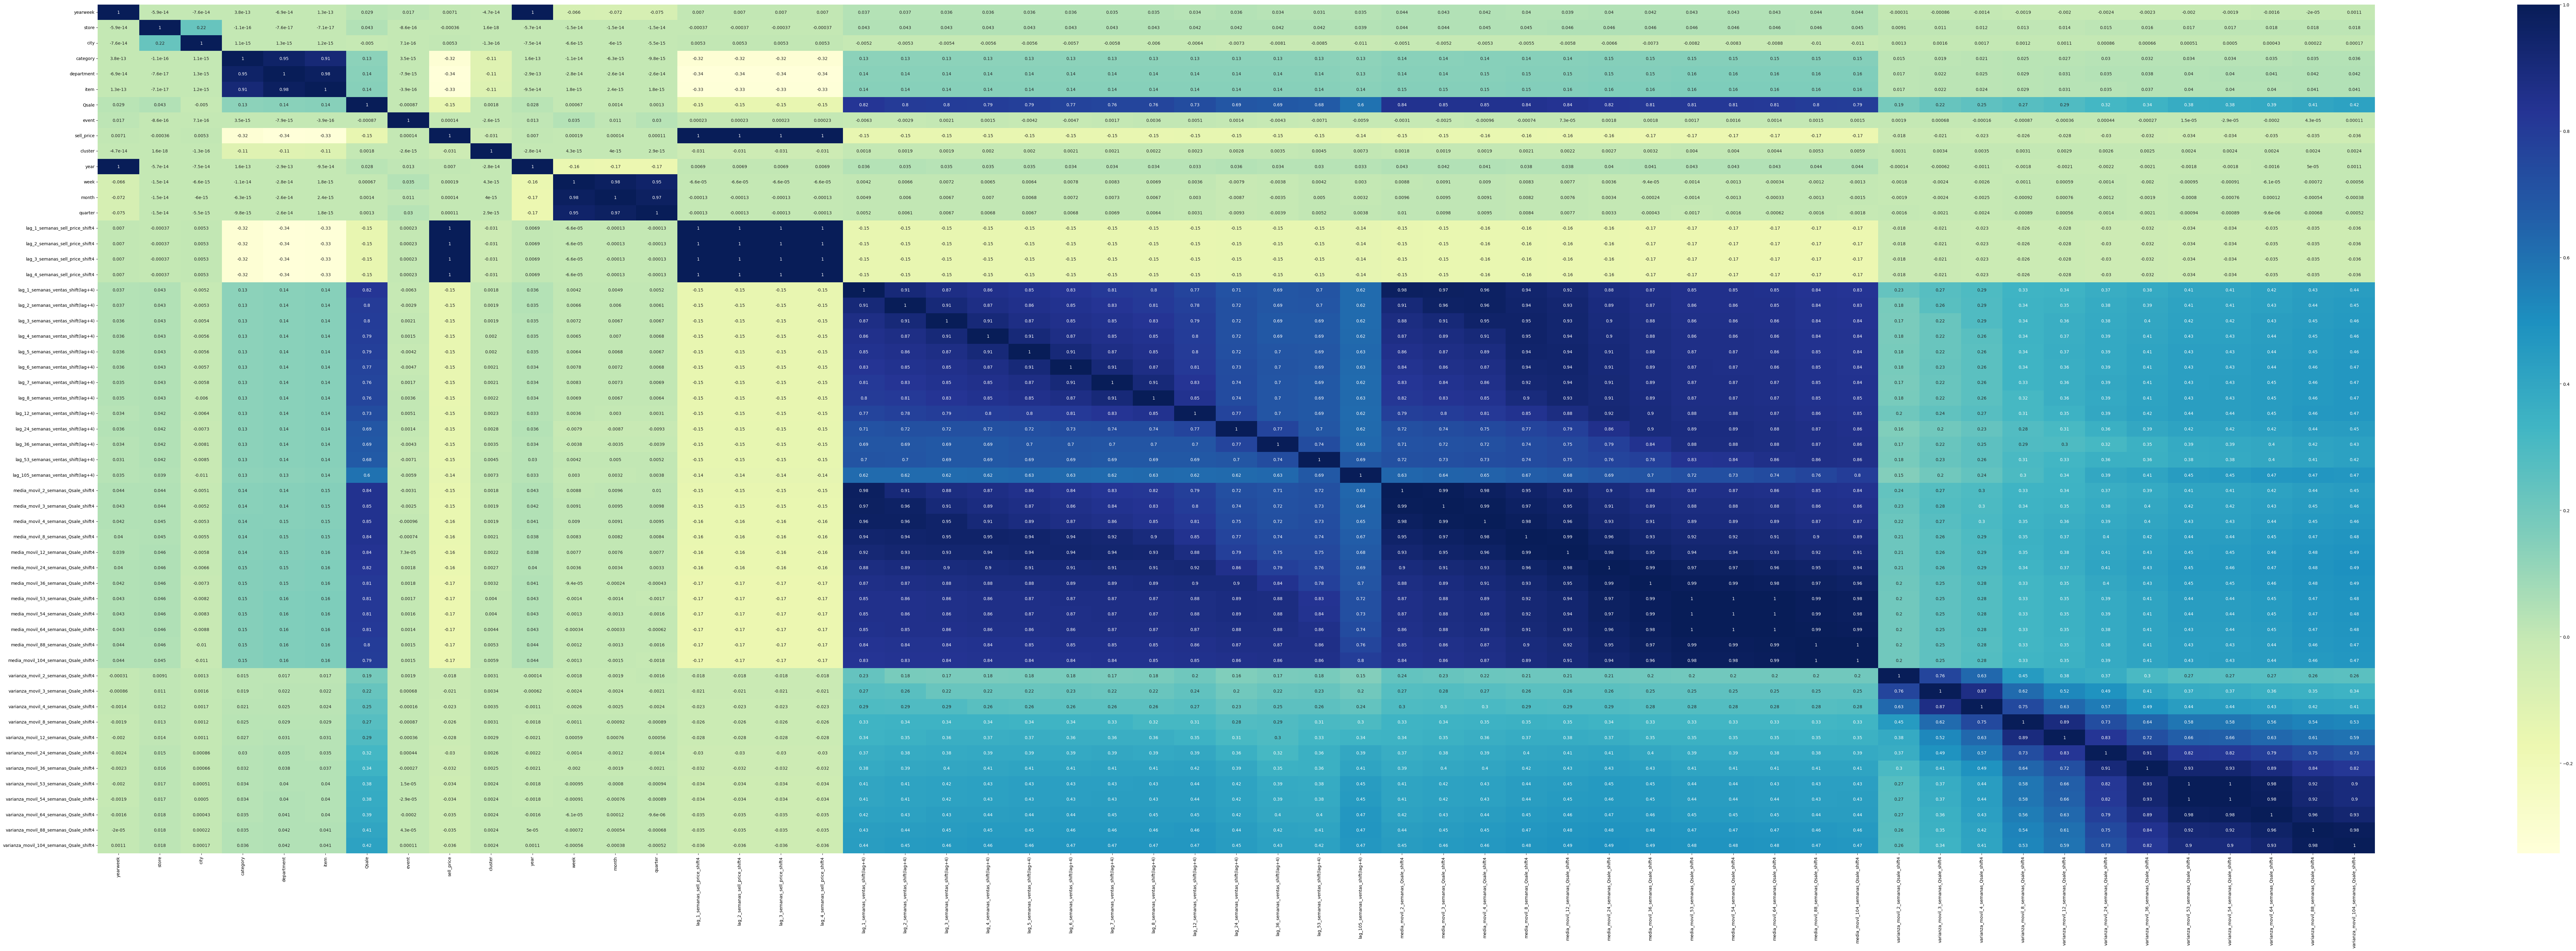

In [75]:
df_corr = df_complete.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(120, 36))
sns.heatmap(data=df_corr, annot=True, cmap='YlGnBu')
plt.show()

In [76]:
# creamos un dataframe triangulo de las correlaciones para evitar que se repitan los valores
df_corr = df_complete.corr(numeric_only=True) 
df_triangulo = pd.DataFrame(np.triu(df_corr, k=1), columns=df_corr.columns, index=df_corr.index)
df_triangulo

yearweek         store          city  \
yearweek                                      0.0 -5.926899e-14 -7.617542e-14   
store                                         0.0  0.000000e+00  2.247333e-01   
city                                          0.0  0.000000e+00  0.000000e+00   
category                                      0.0  0.000000e+00  0.000000e+00   
department                                    0.0  0.000000e+00  0.000000e+00   
item                                          0.0  0.000000e+00  0.000000e+00   
Qsale                                         0.0  0.000000e+00  0.000000e+00   
event                                         0.0  0.000000e+00  0.000000e+00   
sell_price                                    0.0  0.000000e+00  0.000000e+00   
cluster                                       0.0  0.000000e+00  0.000000e+00   
year                                          0.0  0.000000e+00  0.000000e+00   
week                                          0.0  0.000000e+00  0.000000e+00   
month                                         0.0  0.000000e+00  0.000000e+00   
quarter                                       0.0  0.000000e+00  0.000000e+00   
lag_1_semanas_sell_price_shift4               0.0  0.000000e+00  0.000000e+00   
lag_2_semanas_sell_price_shift4               0.0  0.000000e+00  0.000000e+00   
lag_3_semanas_sell_price_shift4               0.0  0.000000e+00  0.000000e+00   
lag_4_semanas_sell_price_shift4               0.0  0.000000e+00  0.000000e+00   
lag_1_semanas_ventas_shift(lag+4)             0.0  0.000000e+00  0.000000e+00   
lag_2_semanas_ventas_shift(lag+4)             0.0  0.000000e+00  0.000000e+00   
lag_3_semanas_ventas_shift(lag+4)             0.0  0.000000e+00  0.000000e+00   
lag_4_semanas_ventas_shift(lag+4)             0.0  0.000000e+00  0.000000e+00   
lag_5_semanas_ventas_shift(lag+4)             0.0  0.000000e+00  0.000000e+00   
lag_6_semanas_ventas_shift(lag+4)             0.0  0.000000e+00  0.000000e+00   
lag_7_semanas_ventas_shift(lag+4)             0.0  0.000000e+00  0.000000e+00   
lag_8_semanas_ventas_shift(lag+4)             0.0  0.000000e+00  0.000000e+00   
lag_12_semanas_ventas_shift(lag+4)            0.0  0.000000e+00  0.000000e+00   
lag_24_semanas_ventas_shift(lag+4)            0.0  0.000000e+00  0.000000e+00   
lag_36_semanas_ventas_shift(lag+4)            0.0  0.000000e+00  0.000000e+00   
lag_53_semanas_ventas_shift(lag+4)            0.0  0.000000e+00  0.000000e+00   
lag_105_semanas_ventas_shift(lag+4)           0.0  0.000000e+00  0.000000e+00   
media_movil_2_semanas_Qsale_shift4            0.0  0.000000e+00  0.000000e+00   
media_movil_3_semanas_Qsale_shift4            0.0  0.000000e+00  0.000000e+00   
media_movil_4_semanas_Qsale_shift4            0.0  0.000000e+00  0.000000e+00   
media_movil_8_semanas_Qsale_shift4            0.0  0.000000e+00  0.000000e+00   
media_movil_12_semanas_Qsale_shift4           0.0  0.000000e+00  0.000000e+00   
media_movil_24_semanas_Qsale_shift4           0.0  0.000000e+00  0.000000e+00   
media_movil_36_semanas_Qsale_shift4           0.0  0.000000e+00  0.000000e+00   
media_movil_53_semanas_Qsale_shift4           0.0  0.000000e+00  0.000000e+00   
media_movil_54_semanas_Qsale_shift4           0.0  0.000000e+00  0.000000e+00   
media_movil_64_semanas_Qsale_shift4           0.0  0.000000e+00  0.000000e+00   
media_movil_88_semanas_Qsale_shift4           0.0  0.000000e+00  0.000000e+00   
media_movil_104_semanas_Qsale_shift4          0.0  0.000000e+00  0.000000e+00   
varianza_movil_2_semanas_Qsale_shift4         0.0  0.000000e+00  0.000000e+00   
varianza_movil_3_semanas_Qsale_shift4         0.0  0.000000e+00  0.000000e+00   
varianza_movil_4_semanas_Qsale_shift4         0.0  0.000000e+00  0.000000e+00   
varianza_movil_8_semanas_Qsale_shift4         0.0  0.000000e+00  0.000000e+00   
varianza_movil_12_semanas_Qsale_shift4        0.0  0.000000e+00  0.000000e+00   
varianza_movil_24_semanas_Qsale_shift4        0.0  0.000000e+00  0.00000

In [77]:
df_altas_correlaciones = df_triangulo.stack().reset_index()
df_altas_correlaciones.columns = ['variable1', 'variable2', 'correlacion']
df_altas_correlaciones = df_altas_correlaciones[df_altas_correlaciones['correlacion'].abs() > 0.95]
df_altas_correlaciones

variable1  \
10                                  yearweek   
169                                 category   
225                               department   
454                               sell_price   
455                               sell_price   
456                               sell_price   
457                               sell_price   
617                                     week   
618                                     week   
673                                    month   
785          lag_1_semanas_sell_price_shift4   
786          lag_1_semanas_sell_price_shift4   
787          lag_1_semanas_sell_price_shift4   
841          lag_2_semanas_sell_price_shift4   
842          lag_2_semanas_sell_price_shift4   
897          lag_3_semanas_sell_price_shift4   
1021       lag_1_semanas_ventas_shift(lag+4)   
1022       lag_1_semanas_ventas_shift(lag+4)   
1023       lag_1_semanas_ventas_shift(lag+4)   
1077       lag_2_semanas_ventas_shift(lag+4)   
1078       lag_2_semanas_ventas_shift(lag+4)   
1737      media_movil_2_semanas_Qsale_shift4   
1738      media_movil_2_semanas_Qsale_shift4   
1793      media_movil_3_semanas_Qsale_shift4   
1794      media_movil_3_semanas_Qsale_shift4   
1849      media_movil_4_semanas_Qsale_shift4   
1850      media_movil_4_semanas_Qsale_shift4   
1905      media_movil_8_semanas_Qsale_shift4   
1906      media_movil_8_semanas_Qsale_shift4   
1961     media_movil_12_semanas_Qsale_shift4   
1962     media_movil_12_semanas_Qsale_shift4   
2017     media_movil_24_semanas_Qsale_shift4   
2018     media_movil_24_semanas_Qsale_shift4   
2019     media_movil_24_semanas_Qsale_shift4   
2020     media_movil_24_semanas_Qsale_shift4   
2073     media_movil_36_semanas_Qsale_shift4   
2074     media_movil_36_semanas_Qsale_shift4   
2075     media_movil_36_semanas_Qsale_shift4   
2076     media_movil_36_semanas_Qsale_shift4   
2077     media_movil_36_semanas_Qsale_shift4   
2129     media_movil_53_semanas_Qsale_shift4   
2130     media_movil_53_semanas_Qsale_shift4   
2131     media_movil_53_semanas_Qsale_shift4   
2132     media_movil_53_semanas_Qsale_shift4   
2185     media_movil_54_semanas_Qsale_shift4   
2186     media_movil_54_semanas_Qsale_shift4   
2187     media_movil_54_semanas_Qsale_shift4   
2241     media_movil_64_semanas_Qsale_shift4   
2242     media_movil_64_semanas_Qsale_shift4   
2297     media_movil_88_semanas_Qsale_shift4   
2801  varianza_movil_53_semanas_Qsale_shift4   
2802  varianza_movil_53_semanas_Qsale_shift4   
2857  varianza_movil_54_semanas_Qsale_shift4   
2913  varianza_movil_64_semanas_Qsale_shift4   
2969  varianza_movil_88_semanas_Qsale_shift4   

                                    variable2  correlacion  
10                                       year     0.995340  
169                                department     0.953052  
225                                      item     0.977926  
454           lag_1_semanas_sell_price_shift4     0.998959  
455           lag_2_semanas_sell_price_shift4     0.998959  
456           lag_3_semanas_sell_price_shift4     0.998959  
457           lag_4_semanas_sell_price_shift4     0.998959  
617                                     month     0.975946  
618                                   quarter     0.951268  
673                                   quarter     0.971446  
785           lag_2_semanas_sell_price_shift4     1.000000  
786           lag_3_semanas_sell_price_shift4     1.000000  
787           lag_4_semanas_sell_price_shift4     1.000000  
841           lag_3_semanas_sell_price_shift4     1.000000  
842           lag_4_semanas_sell_price_shift4     1.000000  
897           lag_4_semanas_sell_price_shift4     1.000000  
1021       media_movil_2_semanas_Qsale_shift4     0.977074  
1022       media_movil_3_semanas_Qsale_shift4     0.973671  
1023       media_movil_4_semanas_Qsale_shift4     0.964000  
1077       media_movil_3_semanas_Qsale_shift4     0.960398  
1078       media_movil_4_semanas_Qsale_shift4     0.963762  
1737

In [78]:
# Filtramos solo las columnas numéricas
df_numeric = df_complete.select_dtypes(include='number')

# Calculamos la correlación con la columna target 'Qsale'
corr_con_target = df_numeric.corr()['Qsale']

# Mostramos el resultado ordenado
corr_con_target = corr_con_target.sort_values(ascending=False)

In [79]:
# añadimos las correlaciones al DataFrame de altas correlaciones
df_altas_correlaciones['corr_var1_target'] = df_altas_correlaciones['variable1'].apply(lambda x: corr_con_target[x])
df_altas_correlaciones['corr_var2_target'] = df_altas_correlaciones['variable2'].apply(lambda x: corr_con_target[x])
df_altas_correlaciones

variable1  \
10                                  yearweek   
169                                 category   
225                               department   
454                               sell_price   
455                               sell_price   
456                               sell_price   
457                               sell_price   
617                                     week   
618                                     week   
673                                    month   
785          lag_1_semanas_sell_price_shift4   
786          lag_1_semanas_sell_price_shift4   
787          lag_1_semanas_sell_price_shift4   
841          lag_2_semanas_sell_price_shift4   
842          lag_2_semanas_sell_price_shift4   
897          lag_3_semanas_sell_price_shift4   
1021       lag_1_semanas_ventas_shift(lag+4)   
1022       lag_1_semanas_ventas_shift(lag+4)   
1023       lag_1_semanas_ventas_shift(lag+4)   
1077       lag_2_semanas_ventas_shift(lag+4)   
1078       lag_2_semanas_ventas_shift(lag+4)   
1737      media_movil_2_semanas_Qsale_shift4   
1738      media_movil_2_semanas_Qsale_shift4   
1793      media_movil_3_semanas_Qsale_shift4   
1794      media_movil_3_semanas_Qsale_shift4   
1849      media_movil_4_semanas_Qsale_shift4   
1850      media_movil_4_semanas_Qsale_shift4   
1905      media_movil_8_semanas_Qsale_shift4   
1906      media_movil_8_semanas_Qsale_shift4   
1961     media_movil_12_semanas_Qsale_shift4   
1962     media_movil_12_semanas_Qsale_shift4   
2017     media_movil_24_semanas_Qsale_shift4   
2018     media_movil_24_semanas_Qsale_shift4   
2019     media_movil_24_semanas_Qsale_shift4   
2020     media_movil_24_semanas_Qsale_shift4   
2073     media_movil_36_semanas_Qsale_shift4   
2074     media_movil_36_semanas_Qsale_shift4   
2075     media_movil_36_semanas_Qsale_shift4   
2076     media_movil_36_semanas_Qsale_shift4   
2077     media_movil_36_semanas_Qsale_shift4   
2129     media_movil_53_semanas_Qsale_shift4   
2130     media_movil_53_semanas_Qsale_shift4   
2131     media_movil_53_semanas_Qsale_shift4   
2132     media_movil_53_semanas_Qsale_shift4   
2185     media_movil_54_semanas_Qsale_shift4   
2186     media_movil_54_semanas_Qsale_shift4   
2187     media_movil_54_semanas_Qsale_shift4   
2241     media_movil_64_semanas_Qsale_shift4   
2242     media_movil_64_semanas_Qsale_shift4   
2297     media_movil_88_semanas_Qsale_shift4   
2801  varianza_movil_53_semanas_Qsale_shift4   
2802  varianza_movil_53_semanas_Qsale_shift4   
2857  varianza_movil_54_semanas_Qsale_shift4   
2913  varianza_movil_64_semanas_Qsale_shift4   
2969  varianza_movil_88_semanas_Qsale_shift4   

                                    variable2  correlacion  corr_var1_target  \
10                                       year     0.995340          0.028692   
169                                department     0.953052          0.133608   
225                                      item     0.977926          0.138410   
454           lag_1_semanas_sell_price_shift4     0.998959         -0.148537   
455           lag_2_semanas_sell_price_shift4     0.998959         -0.148537   
456           lag_3_semanas_sell_price_shift4     0.998959         -0.148537   
457           lag_4_semanas_sell_price_shift4     0.998959         -0.148537   
617                                     month     0.975946          0.000671   
618                                   quarter     0.951268          0.000671   
673                                   quarter     0.971446          0.001375   
785           lag_2_semanas_sell_price_shift4     1.000000         -0.148985   
786           lag_3_semanas_sell_price_shift4     1.000000         -0.148985   
787           lag_4_semanas_sell_price_shift4     1.000000         -0.148985   
841           lag_3_semanas_sell_price_shift4     1.000000         -0.148985   
842           lag_4_semanas_sell_price_shift4     1.000000         -0.148985   
897           lag_4_semanas_sell_price_shift4     1.000000        

In [80]:
# añadimos la variable menos correlacionada con la target del par de variables altamente correlaciones
df_altas_correlaciones['var_menos_corr'] = df_altas_correlaciones.apply(
    lambda linea: linea['variable1'] if np.abs(linea['corr_var1_target']) < np.abs(linea['corr_var2_target']) else linea['variable2'], axis=1)
df_altas_correlaciones

variable1  \
10                                  yearweek   
169                                 category   
225                               department   
454                               sell_price   
455                               sell_price   
456                               sell_price   
457                               sell_price   
617                                     week   
618                                     week   
673                                    month   
785          lag_1_semanas_sell_price_shift4   
786          lag_1_semanas_sell_price_shift4   
787          lag_1_semanas_sell_price_shift4   
841          lag_2_semanas_sell_price_shift4   
842          lag_2_semanas_sell_price_shift4   
897          lag_3_semanas_sell_price_shift4   
1021       lag_1_semanas_ventas_shift(lag+4)   
1022       lag_1_semanas_ventas_shift(lag+4)   
1023       lag_1_semanas_ventas_shift(lag+4)   
1077       lag_2_semanas_ventas_shift(lag+4)   
1078       lag_2_semanas_ventas_shift(lag+4)   
1737      media_movil_2_semanas_Qsale_shift4   
1738      media_movil_2_semanas_Qsale_shift4   
1793      media_movil_3_semanas_Qsale_shift4   
1794      media_movil_3_semanas_Qsale_shift4   
1849      media_movil_4_semanas_Qsale_shift4   
1850      media_movil_4_semanas_Qsale_shift4   
1905      media_movil_8_semanas_Qsale_shift4   
1906      media_movil_8_semanas_Qsale_shift4   
1961     media_movil_12_semanas_Qsale_shift4   
1962     media_movil_12_semanas_Qsale_shift4   
2017     media_movil_24_semanas_Qsale_shift4   
2018     media_movil_24_semanas_Qsale_shift4   
2019     media_movil_24_semanas_Qsale_shift4   
2020     media_movil_24_semanas_Qsale_shift4   
2073     media_movil_36_semanas_Qsale_shift4   
2074     media_movil_36_semanas_Qsale_shift4   
2075     media_movil_36_semanas_Qsale_shift4   
2076     media_movil_36_semanas_Qsale_shift4   
2077     media_movil_36_semanas_Qsale_shift4   
2129     media_movil_53_semanas_Qsale_shift4   
2130     media_movil_53_semanas_Qsale_shift4   
2131     media_movil_53_semanas_Qsale_shift4   
2132     media_movil_53_semanas_Qsale_shift4   
2185     media_movil_54_semanas_Qsale_shift4   
2186     media_movil_54_semanas_Qsale_shift4   
2187     media_movil_54_semanas_Qsale_shift4   
2241     media_movil_64_semanas_Qsale_shift4   
2242     media_movil_64_semanas_Qsale_shift4   
2297     media_movil_88_semanas_Qsale_shift4   
2801  varianza_movil_53_semanas_Qsale_shift4   
2802  varianza_movil_53_semanas_Qsale_shift4   
2857  varianza_movil_54_semanas_Qsale_shift4   
2913  varianza_movil_64_semanas_Qsale_shift4   
2969  varianza_movil_88_semanas_Qsale_shift4   

                                    variable2  correlacion  corr_var1_target  \
10                                       year     0.995340          0.028692   
169                                department     0.953052          0.133608   
225                                      item     0.977926          0.138410   
454           lag_1_semanas_sell_price_shift4     0.998959         -0.148537   
455           lag_2_semanas_sell_price_shift4     0.998959         -0.148537   
456           lag_3_semanas_sell_price_shift4     0.998959         -0.148537   
457           lag_4_semanas_sell_price_shift4     0.998959         -0.148537   
617                                     month     0.975946          0.000671   
618                                   quarter     0.951268          0.000671   
673                                   quarter     0.971446          0.001375   
785           lag_2_semanas_sell_price_shift4     1.000000         -0.148985   
786           lag_3_semanas_sell_price_shift4     1.000000         -0.148985   
787           lag_4_semanas_sell_price_shift4     1.000000         -0.148985   
841           lag_3_semanas_sell_price_shift4     1.000000         -0.148985   
842           lag_4_semanas_sell_price_shift4     1.000000         -0.148985   
897           lag_4_semanas_sell_price_shift4     1.000000        

In [81]:
# vemos que hay grupos de 3 variables altamente correlaciondas (max, min, med)
var_menos_corr = list(set(df_altas_correlaciones['var_menos_corr']))
var_menos_corr

['lag_3_semanas_sell_price_shift4',
 'media_movil_12_semanas_Qsale_shift4',
 'varianza_movil_53_semanas_Qsale_shift4',
 'media_movil_104_semanas_Qsale_shift4',
 'varianza_movil_64_semanas_Qsale_shift4',
 'lag_2_semanas_ventas_shift(lag+4)',
 'media_movil_24_semanas_Qsale_shift4',
 'department',
 'lag_4_semanas_sell_price_shift4',
 'quarter',
 'category',
 'year',
 'media_movil_53_semanas_Qsale_shift4',
 'lag_2_semanas_sell_price_shift4',
 'media_movil_2_semanas_Qsale_shift4',
 'media_movil_36_semanas_Qsale_shift4',
 'media_movil_8_semanas_Qsale_shift4',
 'media_movil_3_semanas_Qsale_shift4',
 'media_movil_54_semanas_Qsale_shift4',
 'media_movil_64_semanas_Qsale_shift4',
 'varianza_movil_54_semanas_Qsale_shift4',
 'varianza_movil_88_semanas_Qsale_shift4',
 'week',
 'lag_1_semanas_ventas_shift(lag+4)',
 'sell_price',
 'media_movil_88_semanas_Qsale_shift4']

In [82]:
var_menos_corr.remove('week')
var_menos_corr.remove('category')

In [83]:
# # eliminamos las variables altamente correlacionadas que aportan menos valor del dataset
df_complete.drop(columns=var_menos_corr, inplace=True)


In [84]:
df_complete.drop(columns=['item','month'],inplace=True)

# Model Train

In [85]:
df_train_test = df_complete[(df_complete['yearweek'] > 201400) & (df_complete['yearweek'] <= 201616)].copy()
# df_train_test = df_complete[(df_complete['yearweek'] <= 201616)].copy()

In [86]:
# Creamos los subsets con cada semana a calcular
# Subset para la primera semana (201617)
df_pred_201617 = df_complete[df_complete['yearweek'] == 201617].copy()   

# Subset para la segunda semana (201618)
df_pred_201618 = df_complete[df_complete['yearweek'] == 201618].copy()   

# Subset para la tercera semana (201619)
df_pred_201619 = df_complete[df_complete['yearweek'] == 201619].copy()

# Subset para la cuarta semana (201620)
df_pred_201620 = df_complete[df_complete['yearweek'] == 201620].copy()

In [87]:
df_train_test = df_train_test.set_index('id')
df_pred_201617 = df_pred_201617.set_index('id')
df_pred_201618 = df_pred_201618.set_index('id')
df_pred_201619 = df_pred_201619.set_index('id')
df_pred_201620 = df_pred_201620.set_index('id')

In [88]:
df_train_test.drop(columns='yearweek',inplace=True)
df_pred_201617.drop(columns='yearweek',inplace=True)
df_pred_201618.drop(columns='yearweek',inplace=True)
df_pred_201619.drop(columns='yearweek',inplace=True)
df_pred_201620.drop(columns='yearweek',inplace=True)

Chequeamos que ambos dfs tengan las columnas en el mismo orden y las mismas columnas

In [89]:
print("Columnas en df_train_test pero no en df_pred_201617:")
print(df_train_test.columns.difference(df_pred_201617.columns))

Columnas en df_train_test pero no en df_pred_201617:
Index([], dtype='object')


In [90]:
print("Columnas en df_train_test pero no en df_pred_201618:")
print(df_train_test.columns.difference(df_pred_201618.columns))

Columnas en df_train_test pero no en df_pred_201618:
Index([], dtype='object')


In [91]:
print("Columnas en df_train_test pero no en df_pred_201619:")
print(df_train_test.columns.difference(df_pred_201619.columns))

Columnas en df_train_test pero no en df_pred_201619:
Index([], dtype='object')


In [92]:
print("Columnas en df_train_test pero no en df_prdf_pred_201620:")
print(df_train_test.columns.difference(df_pred_201620.columns))

Columnas en df_train_test pero no en df_prdf_pred_201620:
Index([], dtype='object')


# Forecast Model

## Model Train

In [93]:
# Lista de clusters
clusters = [1, 2, 3, 4, 5, 6, 7]

In [94]:
# Crear diccionario con semanas futuras
future_weeks = {
    201617: df_pred_201617,
    201618: df_pred_201618,
    201619: df_pred_201619,
    201620: df_pred_201620,
}
# Lista para almacenar los resultados
lista_predicciones = []

In [95]:
# Inicializar estructuras
test_results = pd.DataFrame(columns=['Future_Week', 'Cluster', 'Test_RMSE', 'Test_MAE', 'Peso', 'Test_RMSE_Ponderado', 'Test_MAE_Ponderado'])
models = {}


In [96]:
for cluster in clusters:
    print(f"Entrenando modelo para cluster: {cluster}")
    
    # Filtrar los datos solo para ese cluster
    df_cluster = df_train_test[df_train_test['cluster'] == cluster].copy()
    
    # Preparar X e y
    X = df_cluster.drop(columns=['Qsale'])
    y = df_cluster['Qsale']
    
    # Dividir datos
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
    
    # Definir y entrenar modelo
    model = XGBRegressor(
        objective='reg:squarederror',
        eval_metric=['rmse', 'mae'],
        max_depth=3,
        min_child_weight=5,
        eta=0.05,
        subsample=0.7,
        early_stopping_rounds=100,
        learning_rate=0.05,
        n_estimators=3000,
        colsample_bytree=0.7,
        reg_lambda=1.0,
        alpha=0.5
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=50
    )

    # Guardar modelo
    models[cluster] = model

    # Evaluar en test set
    y_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_mae = mean_absolute_error(y_test, y_pred)
    peso = len(y_test)

    df_preds_cluster = X_test.copy()
    df_preds_cluster['y_real'] = y_test.values
    df_preds_cluster['y_pred'] = y_pred
    df_preds_cluster['cluster'] = cluster
    lista_predicciones.append(df_preds_cluster)

    nuevo_resultado = pd.DataFrame([{
        'Future_Week': '4 semanas',
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae,
        'Cluster': cluster,
        'Peso': peso,
        'Test_RMSE_Ponderado': test_rmse * peso,
        'Test_MAE_Ponderado': test_mae * peso
    }])

    test_results = pd.concat([test_results, nuevo_resultado], ignore_index=True)

Entrenando modelo para cluster: 1
[0]	validation_0-rmse:7.77714	validation_0-mae:4.67916	validation_1-rmse:8.65750	validation_1-mae:4.91736
[50]	validation_0-rmse:4.79504	validation_0-mae:2.60544	validation_1-rmse:5.28214	validation_1-mae:2.74600
[100]	validation_0-rmse:4.66045	validation_0-mae:2.51807	validation_1-rmse:5.10429	validation_1-mae:2.66938
[150]	validation_0-rmse:4.61303	validation_0-mae:2.50082	validation_1-rmse:5.07141	validation_1-mae:2.65796
[200]	validation_0-rmse:4.56892	validation_0-mae:2.48996	validation_1-rmse:5.06656	validation_1-mae:2.65613
[250]	validation_0-rmse:4.53612	validation_0-mae:2.48177	validation_1-rmse:5.06756	validation_1-mae:2.65391
[300]	validation_0-rmse:4.50447	validation_0-mae:2.47250	validation_1-rmse:5.06273	validation_1-mae:2.65075
[350]	validation_0-rmse:4.47550	validation_0-mae:2.46420	validation_1-rmse:5.05677	validation_1-mae:2.64679
[400]	validation_0-rmse:4.45363	validation_0-mae:2.45959	validation_1-rmse:5.06126	validation_1-mae:2.645

C:\Users\gaspi\AppData\Local\Temp\ipykernel_14988\213455466.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_results = pd.concat([test_results, nuevo_resultado], ignore_index=True)


[0]	validation_0-rmse:8.96331	validation_0-mae:5.63637	validation_1-rmse:8.99888	validation_1-mae:5.49256
[50]	validation_0-rmse:5.94926	validation_0-mae:3.38968	validation_1-rmse:6.08663	validation_1-mae:3.50241
[100]	validation_0-rmse:5.83210	validation_0-mae:3.27901	validation_1-rmse:6.07021	validation_1-mae:3.43885
[150]	validation_0-rmse:5.78636	validation_0-mae:3.25509	validation_1-rmse:6.05418	validation_1-mae:3.42391
[200]	validation_0-rmse:5.75804	validation_0-mae:3.24443	validation_1-rmse:6.04828	validation_1-mae:3.41764
[250]	validation_0-rmse:5.73409	validation_0-mae:3.23634	validation_1-rmse:6.03950	validation_1-mae:3.41163
[300]	validation_0-rmse:5.71499	validation_0-mae:3.23052	validation_1-rmse:6.03870	validation_1-mae:3.40842
[350]	validation_0-rmse:5.69464	validation_0-mae:3.22388	validation_1-rmse:6.03232	validation_1-mae:3.40460
[400]	validation_0-rmse:5.67767	validation_0-mae:3.21732	validation_1-rmse:6.02878	validation_1-mae:3.40213
[450]	validation_0-rmse:5.66237

In [97]:
# Total peso para porcentaje
total_peso = test_results['Peso'].sum()

# Calcular el peso en porcentaje
test_results['Peso'] = test_results['Peso'] / total_peso * 100

# Calcular columnas ponderadas normalizadas
test_results['Test_RMSE_Ponderado_Normalizado'] = test_results['Test_RMSE_Ponderado'] / total_peso
test_results['Test_MAE_Ponderado_Normalizado'] = test_results['Test_MAE_Ponderado'] / total_peso

# Eliminar columnas de ponderados sin normalizar
test_results = test_results.drop(columns=['Test_RMSE_Ponderado', 'Test_MAE_Ponderado'])

# Mostrar errores globales ponderados normalizados
rmse_ponderado = test_results['Test_RMSE_Ponderado_Normalizado'].sum()
mae_ponderado = test_results['Test_MAE_Ponderado_Normalizado'].sum()

print(f"RMSE ponderado global: {rmse_ponderado:.2f}")
print(f"MAE ponderado global: {mae_ponderado:.2f}")

# Redondear columnas para mejor visualización
cols_round_2 = ['Test_RMSE', 'Test_MAE', 'Peso', 
                'Test_RMSE_Ponderado_Normalizado', 'Test_MAE_Ponderado_Normalizado']

test_results[cols_round_2] = test_results[cols_round_2].round(2)
df_preds_all = pd.concat(lista_predicciones, ignore_index=True)

RMSE ponderado global: 9.00
MAE ponderado global: 4.07


In [98]:
test_results


Future_Week Cluster  Test_RMSE  Test_MAE       Peso  \
0   4 semanas       1       5.23      2.73  10.134515   
1   4 semanas       2       5.62      3.25  20.728014   
2   4 semanas       3      11.71      4.89  10.396895   
3   4 semanas       4      22.61      9.67   11.11844   
4   4 semanas       5       4.14      2.31  14.266999   
5   4 semanas       6       8.43      3.61  23.089433   
6   4 semanas       7      10.10      3.65  10.265705   

   Test_RMSE_Ponderado_Normalizado  Test_MAE_Ponderado_Normalizado  
0                             0.53                            0.28  
1                             1.16                            0.67  
2                             1.22                            0.51  
3                             2.51                            1.07  
4                             0.59                            0.33  
5                             1.95                            0.83  
6                             1.04                            0.37

In [99]:
with open('test_results.pkl', 'wb') as file:  
    pickle.dump(test_results, file)   

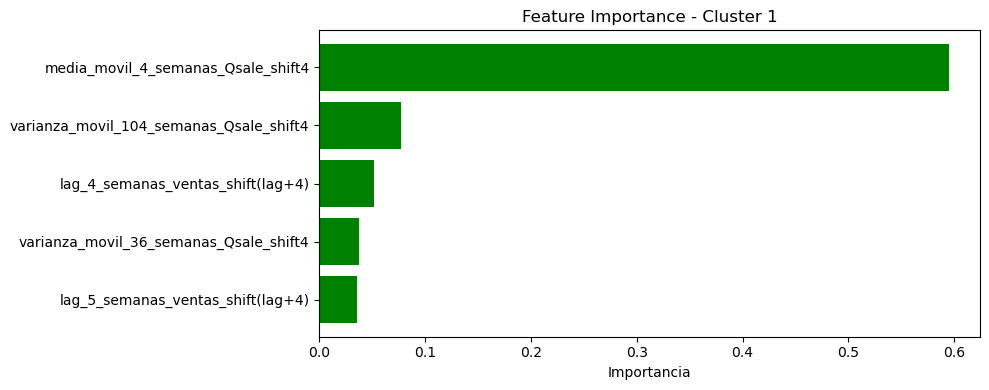

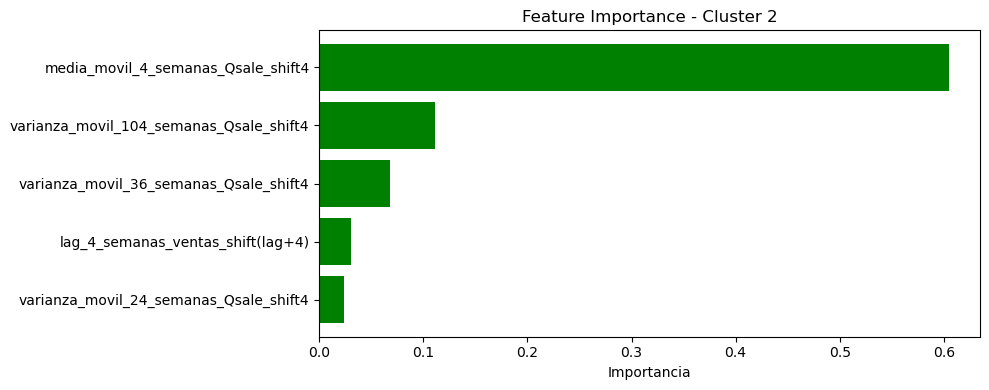

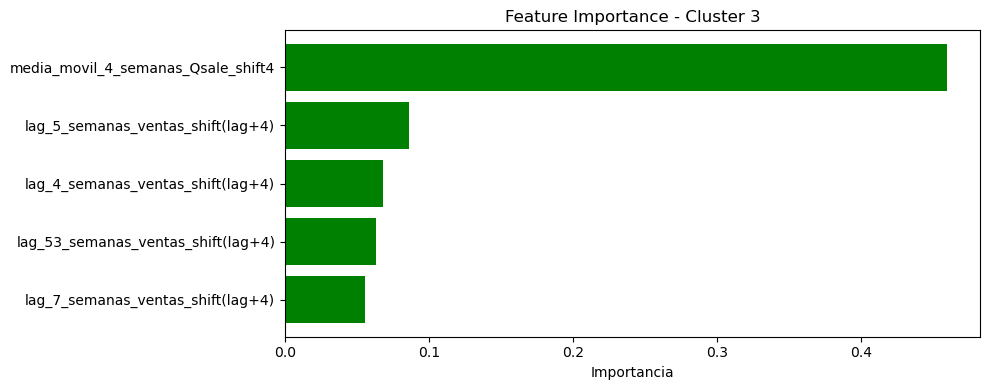

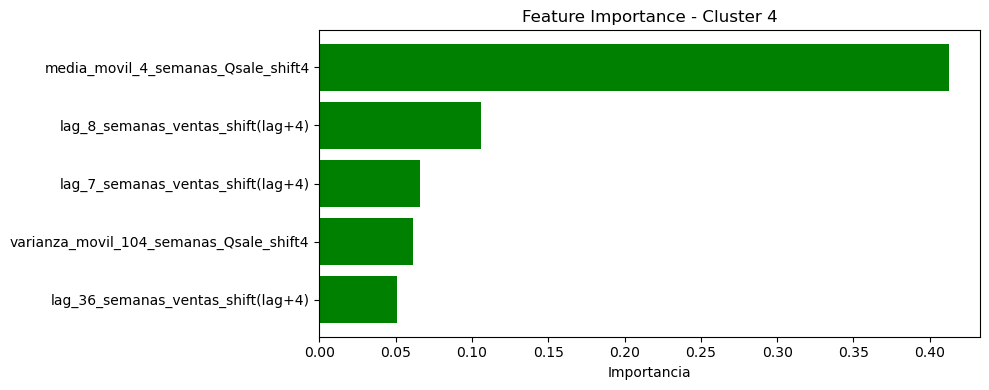

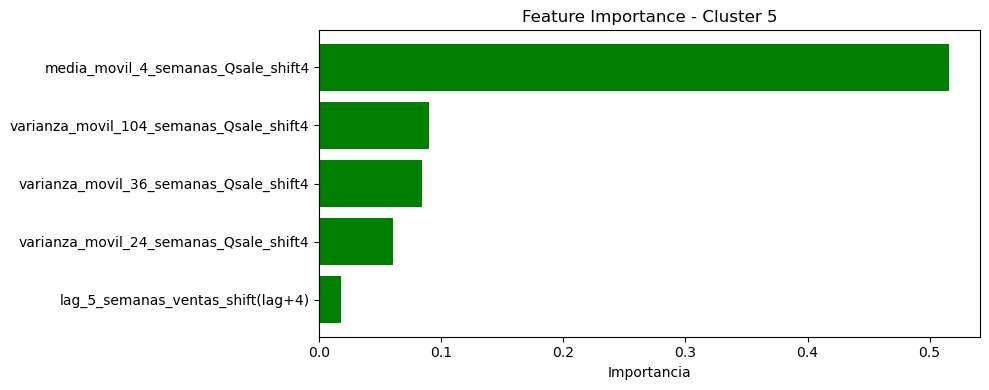

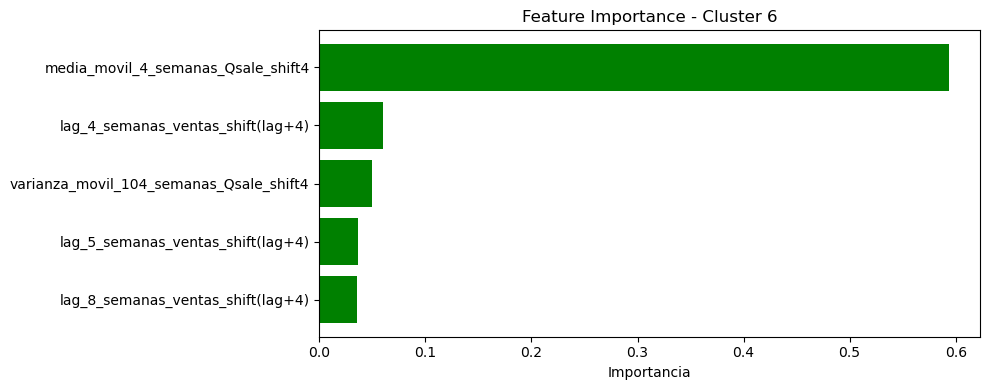

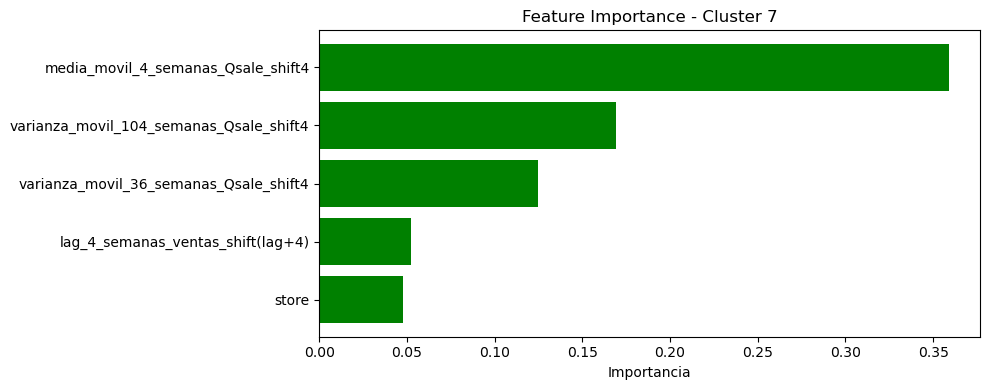

In [100]:
for cluster, modelo in models.items():

    # Obtener las importancias de las features
    importancias = modelo.feature_importances_

    # Obtener nombres de columnas (features)
    df_cluster = df_train_test[df_train_test['cluster'] == cluster].copy()
    X = df_cluster.drop(columns=['Qsale'])
    nombres_columnas = X.columns    

    # Crear DataFrame con resultados
    df_importancias = pd.DataFrame({
        'Feature': nombres_columnas,
        'Importance': importancias
    }).sort_values(by='Importance', ascending=False).head(5)

    # Gráfico de barras
    plt.figure(figsize=(10, 4))
    plt.barh(df_importancias['Feature'], df_importancias['Importance'], color='green')
    plt.gca().invert_yaxis()
    plt.title(f"Feature Importance - Cluster {cluster}")
    plt.xlabel("Importancia")
    plt.tight_layout()
    plt.show()


## Prediction

In [101]:
# Recorrer cada cluster
for cluster in range(1, 8):  # Clusters del 1 al 7
    model = models[cluster]  # Recuperar modelo ya entrenado

    for semana, df_semana in future_weeks.items():
        # Filtrar por cluster
        df_future_cluster = df_semana[df_semana['cluster'] == cluster].copy()

        # Predecir si hay datos
        if not df_future_cluster.empty:
            X_future = df_future_cluster.drop(columns=['Qsale'], errors='ignore')
            y_pred = model.predict(X_future)

            df_future_cluster['Qsale'] = y_pred  # Reemplazar Qsale con predicción
            df_future_cluster['yearweek'] = semana  # Columna opcional
            lista_predicciones.append(df_future_cluster)


In [102]:
# Concatenar todas las predicciones
df_futuro_total = pd.concat(lista_predicciones).reset_index()

In [103]:
df_futuro_total['year'] = 2016

In [104]:
df_futuro_total

id  store  city  category  event  \
0             SUPERMARKET_3_338_Roxbury    7.0   1.0       3.0      0   
1           SUPERMARKET_3_338_South_End    8.0   1.0       3.0      0   
2             SUPERMARKET_3_338_Tribeca    9.0   2.0       3.0      0   
3            SUPERMARKET_3_338_Yorktown   10.0   3.0       3.0      0   
4            SUPERMARKET_3_340_Back_Bay    1.0   1.0       3.0      0   
...                                 ...    ...   ...       ...    ...   
675351  SUPERMARKET_3_819_Queen_Village    6.0   3.0       3.0      0   
675352        SUPERMARKET_3_819_Roxbury    7.0   1.0       3.0      0   
675353      SUPERMARKET_3_819_South_End    8.0   1.0       3.0      0   
675354        SUPERMARKET_3_819_Tribeca    9.0   2.0       3.0      0   
675355       SUPERMARKET_3_819_Yorktown   10.0   3.0       3.0      0   

        cluster  week  lag_1_semanas_sell_price_shift4  \
0             1    51                            4.416   
1             1    51                            4.416   
2             1    51                            4.416   
3             1    51                            4.416   
4             1    51                            3.984   
...         ...   ...                              ...   
675351        7    20                            2.376   
675352        7    20                            2.376   
675353        7    20                            2.376   
675354        7    20                            2.376   
675355        7    20                            2.376   

        lag_3_semanas_ventas_shift(lag+4)  lag_4_semanas_ventas_shift(lag+4)  \
0                                     0.0                                0.0   
1                                     0.0                                0.0   
2                                     3.0                                2.0   
3                                     2.0                                1.0   
4                                     2.0                                1.0   
...                                   ...                                ...   
675351                               17.0                               14.0   
675352                                6.0                                4.0   
675353                                1.0                                5.0   
675354                                5.0                               16.0   
675355                               12.0                               18.0   

        lag_5_semanas_ventas_shift(lag+4)  lag_6_semanas_ventas_shift(lag+4)  \
0                                     0.0                                0.0   
1                                     0.0                                0.0   
2                                     2.0                                4.0   
3                                     2.0                                2.0   
4                                     4.0                                5.0   
...                                   ...                                ...   
675351                               16.0                               14.0   
675352                                1.0                                1.0   
675353                                4.0                                1.0   
675354                                9.0                               21.0   
675355                               14.0                               15.0   

        lag_7_semanas_ventas_shift(lag+4)  lag_8_semanas_ventas_shift(lag+4)  \
0                                     1.0                                0.0   
1                                     0.0                                0.0   
2                                     4.0                                5.0   
3                                     2.0                                3.0   
4                                     7.0                                5.0   
...                                   ...                    

In [105]:
df_comparisson = df_futuro_total.copy()

In [106]:
df_comparisson['yearweek'] = (df_comparisson['year']*100)+df_comparisson['week']

In [107]:
# Filtrar semanas de la 1 a la 16 del 2016
df_semanas = df_comparisson[
    (df_comparisson['yearweek'] >= 201601) & (df_comparisson['yearweek'] <= 201616)
].copy()

# Agrupar por cluster y semana
df_summary = df_semanas.groupby(['cluster', 'yearweek'])[['y_real', 'y_pred']].sum().reset_index()

# Gráfico: uno por cluster
clusters_unicos = sorted(df_summary['cluster'].unique())


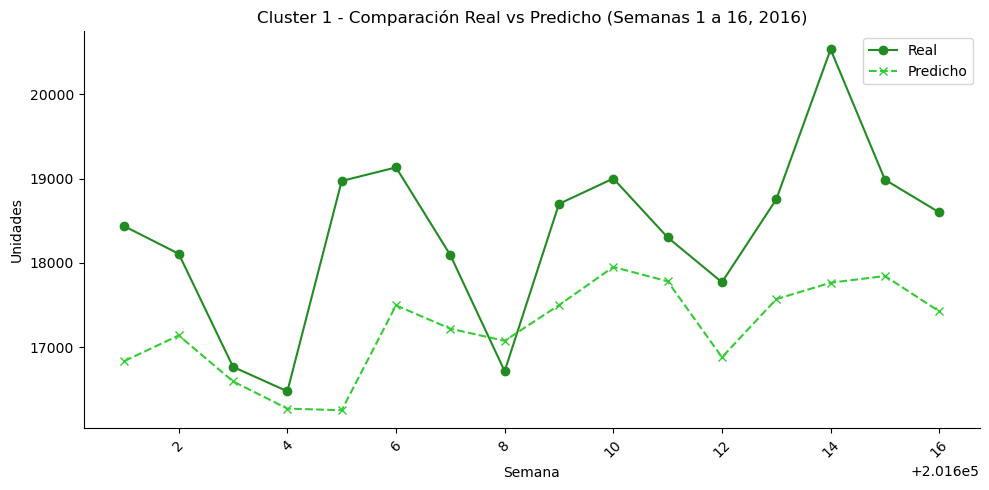

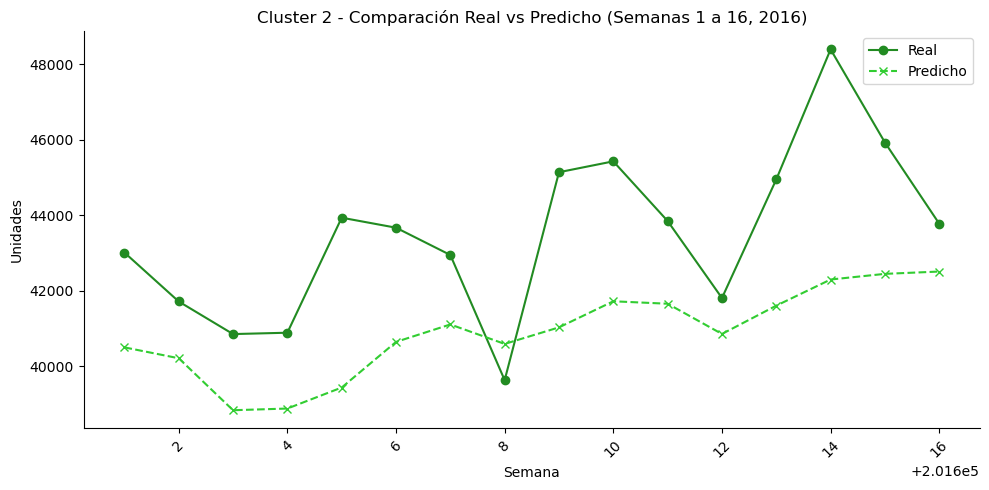

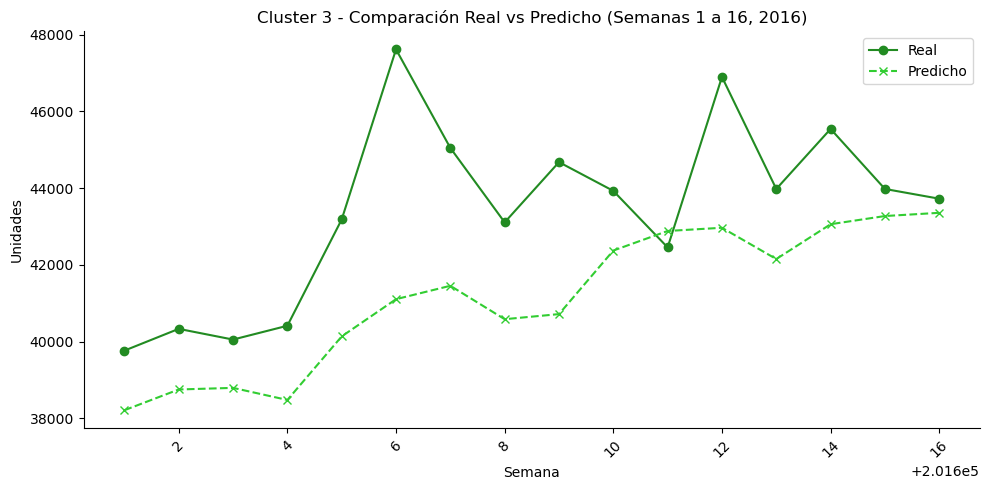

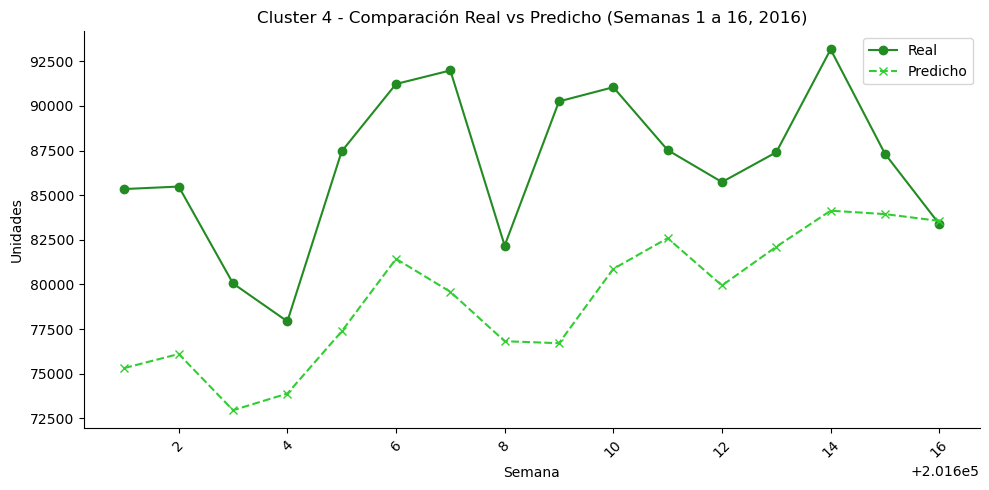

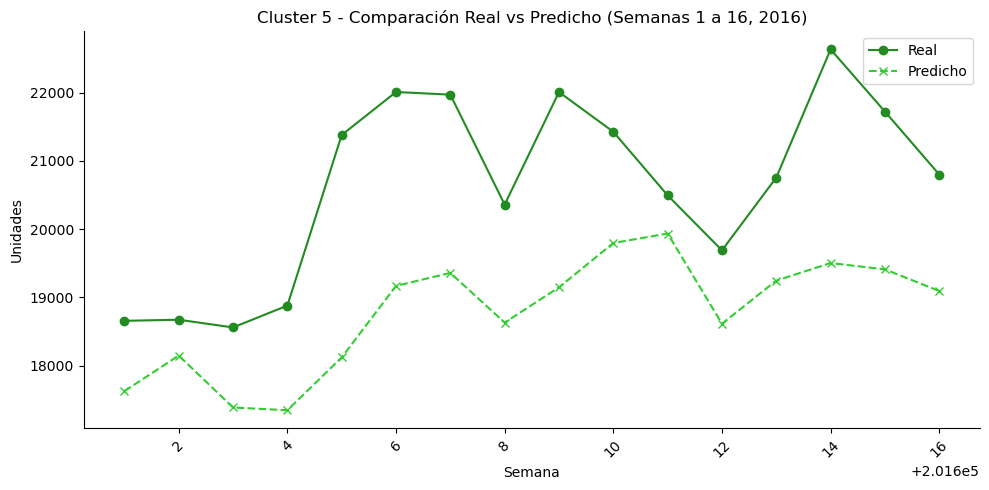

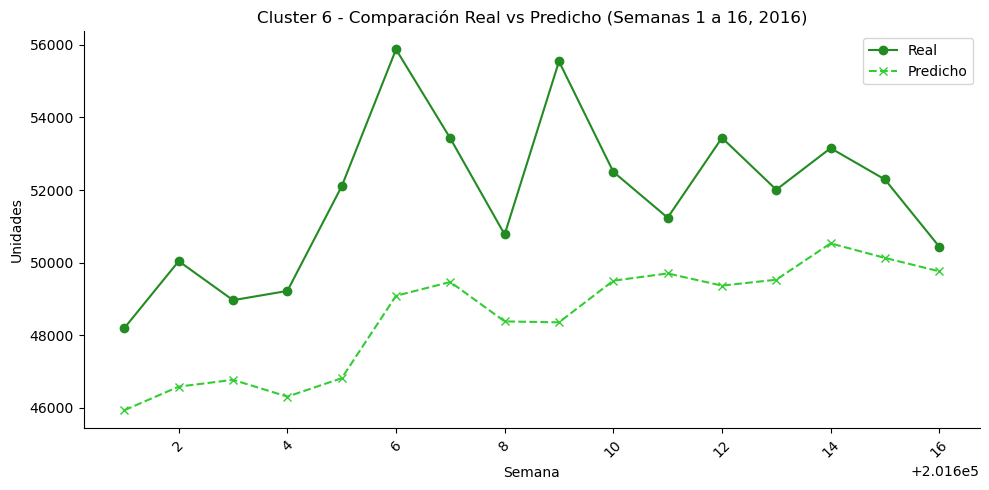

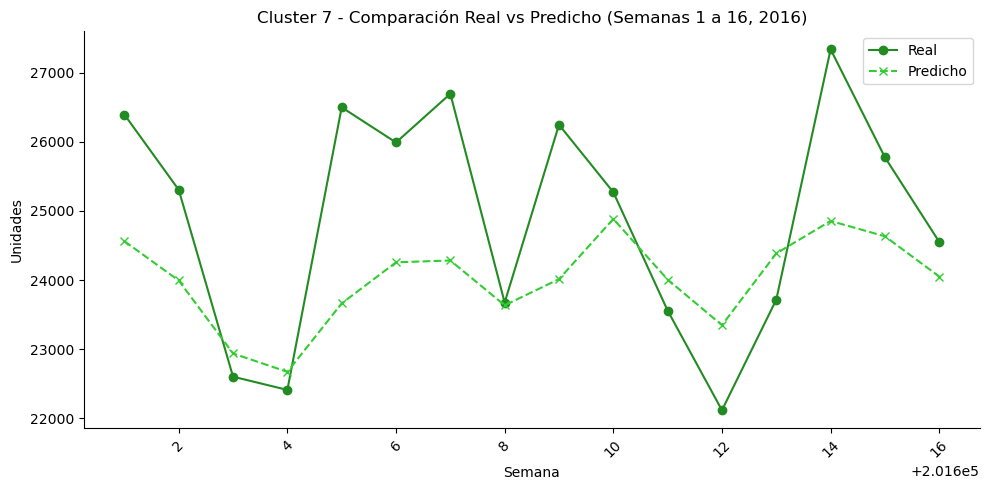

In [108]:
for cluster in clusters_unicos:
    df_plot = df_summary[df_summary['cluster'] == cluster]

    plt.figure(figsize=(10, 5))

    # Líneas en tonos verdes
    plt.plot(df_plot['yearweek'], df_plot['y_real'], marker='o', color='forestgreen', label='Real')
    plt.plot(df_plot['yearweek'], df_plot['y_pred'], marker='x', color='limegreen', linestyle='--', label='Predicho')

    plt.title(f"Cluster {cluster} - Comparación Real vs Predicho (Semanas 1 a 16, 2016)")
    plt.xlabel("Semana")
    plt.ylabel("Unidades")
    plt.xticks(rotation=45)
    plt.legend()

    # Quitar grid
    plt.grid(False)

    # Quitar recuadro (spines)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

# Final result

## creamos df final con predicciones

In [109]:
columnas_df.append('id')

In [110]:
# Asegúrate de que columnas_df sea una lista
columnas_referencia = set(columnas_df)

# Columnas del DataFrame
columnas_actuales = set(df_futuro_total.columns)

# Columnas que están en columnas_df pero no en df_futuro_total
faltantes = list(columnas_referencia - columnas_actuales)

print(faltantes)

['department', 'item', 'quarter', 'month', 'sell_price']


In [111]:
columnas_columnas_df = [col for col in columnas_df if col in df_futuro_total.columns]

In [112]:
df_prediccion = df_futuro_total[columnas_columnas_df]

In [113]:
# creamos columnas item y department
df_prediccion['item'] = df_prediccion['id'].str.extract(r'^(.+?_\d{3})')
df_prediccion['department'] = df_prediccion['id'].str.extract(r'^(.+?_\d+)_\d{3}')

C:\Users\gaspi\AppData\Local\Temp\ipykernel_14988\3233150346.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediccion['item'] = df_prediccion['id'].str.extract(r'^(.+?_\d{3})')
C:\Users\gaspi\AppData\Local\Temp\ipykernel_14988\3233150346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediccion['department'] = df_prediccion['id'].str.extract(r'^(.+?_\d+)_\d{3}')


In [114]:
# Crear una columna de tipo datetime desde year y week (asignamos el día 1 de la semana)
df_prediccion['date'] = pd.to_datetime(df_prediccion['year'].astype(str) + df_prediccion['week'].astype(str) + '1', format='%G%V%u')

C:\Users\gaspi\AppData\Local\Temp\ipykernel_14988\1068809222.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediccion['date'] = pd.to_datetime(df_prediccion['year'].astype(str) + df_prediccion['week'].astype(str) + '1', format='%G%V%u')


In [115]:
df_prediccion['month'] = df_prediccion['date'].dt.month
df_prediccion['quarter'] = df_prediccion['date'].dt.quarter

C:\Users\gaspi\AppData\Local\Temp\ipykernel_14988\4121403633.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediccion['month'] = df_prediccion['date'].dt.month
C:\Users\gaspi\AppData\Local\Temp\ipykernel_14988\4121403633.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediccion['quarter'] = df_prediccion['date'].dt.quarter


In [116]:
df_prediccion.drop(columns='date',inplace=True)

C:\Users\gaspi\AppData\Local\Temp\ipykernel_14988\1045112474.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediccion.drop(columns='date',inplace=True)


In [117]:
df_prediccion['sell_price'] = np.nan

C:\Users\gaspi\AppData\Local\Temp\ipykernel_14988\1144786191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediccion['sell_price'] = np.nan


In [118]:
df_ventas = df_final_encoded[columnas_df]
df_ventas = df_ventas[df_ventas['yearweek']<201617]

In [119]:
# Columnas en cada DataFrame
cols_ventas = set(df_ventas.columns)
cols_prediccion = set(df_prediccion.columns)

# Columnas que están en uno pero no en otro
solo_en_ventas = cols_ventas - cols_prediccion
solo_en_prediccion = cols_prediccion - cols_ventas

print("Columnas sólo en df_ventas:", solo_en_ventas)
print("Columnas sólo en df_prediccion:", solo_en_prediccion)

# ¿Tienen las mismas columnas?
if cols_ventas == cols_prediccion:
    print("Ambos DataFrames tienen las mismas columnas.")
else:
    print("Los DataFrames tienen columnas diferentes.")

Columnas sólo en df_ventas: set()
Columnas sólo en df_prediccion: set()
Ambos DataFrames tienen las mismas columnas.


In [120]:
df_prediccion = df_prediccion[df_ventas.columns]

In [121]:
df_final_wpred = pd.concat([df_ventas, df_prediccion], ignore_index=True)

In [122]:
df_final_wpred

yearweek  store  city  category     department               item  \
0        201105.0    1.0   1.0       1.0            1.0                1.0   
1        201105.0    1.0   1.0       1.0            1.0                2.0   
2        201105.0    1.0   1.0       1.0            1.0                3.0   
3        201105.0    1.0   1.0       1.0            1.0                4.0   
4        201105.0    1.0   1.0       1.0            1.0                5.0   
...           ...    ...   ...       ...            ...                ...   
8999121  201620.0    6.0   3.0       3.0  SUPERMARKET_3  SUPERMARKET_3_819   
8999122  201620.0    7.0   1.0       3.0  SUPERMARKET_3  SUPERMARKET_3_819   
8999123  201620.0    8.0   1.0       3.0  SUPERMARKET_3  SUPERMARKET_3_819   
8999124  201620.0    9.0   2.0       3.0  SUPERMARKET_3  SUPERMARKET_3_819   
8999125  201620.0   10.0   3.0       3.0  SUPERMARKET_3  SUPERMARKET_3_819   

             Qsale  event  sell_price  cluster  year  week  month  quarter  \
0         0.000000      1     11.4646        5  2011     5      1        1   
1         0.000000      1      5.2801        6  2011     5      1        1   
2         0.000000      1      3.9501        6  2011     5      1        1   
3         0.000000      1      5.0141        4  2011     5      1        1   
4         0.000000      1      3.9634        6  2011     5      1        1   
...            ...    ...         ...      ...   ...   ...    ...      ...   
8999121  14.468577      0         NaN        7  2016    20      5        2   
8999122   6.125085      0         NaN        7  2016    20      5        2   
8999123   2.356717      0         NaN        7  2016    20      5        2   
8999124   8.786244      0         NaN        7  2016    20      5        2   
8999125  13.438486      0         NaN        7  2016    20      5        2   

                                      id  
0              ACCESORIES_1_001_Back_Bay  
1              ACCESORIES_1_002_Back_Bay  
2              ACCESORIES_1_003_Back_Bay  
3              ACCESORIES_1_004_Back_Bay  
4              ACCESORIES_1_005_Back_Bay  
...                                  ...  
8999121  SUPERMARKET_3_819_Queen_Village  
8999122        SUPERMARKET_3_819_Roxbury  
8999123      SUPERMARKET_3_819_South_End  
8999124        SUPERMARKET_3_819_Tribeca  
8999125       SUPERMARKET_3_819_Yorktown  

[8999126 rows x 15 columns]

In [123]:
columns_to_replace = ['store', 'city', 'category', 'department', 'item']

for col in columns_to_replace:
    # Crear diccionario de mapeo desde df_mappings
    mapping_dict = df_mappings[col].dropna().reset_index().set_index('index')[col].to_dict()

    # Reemplazar en df_final_wpred y mantener valores originales si no están en el diccionario
    df_final_wpred[col] = df_final_wpred[col].map(mapping_dict).fillna(df_final_wpred[col])

In [124]:
df_final_wpred

yearweek          store          city     category     department  \
0        201105.0       Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
1        201105.0       Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
2        201105.0       Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
3        201105.0       Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
4        201105.0       Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
...           ...            ...           ...          ...            ...   
8999121  201620.0  Queen_Village  Philadelphia  SUPERMARKET  SUPERMARKET_3   
8999122  201620.0        Roxbury        Boston  SUPERMARKET  SUPERMARKET_3   
8999123  201620.0      South_End        Boston  SUPERMARKET  SUPERMARKET_3   
8999124  201620.0        Tribeca      New York  SUPERMARKET  SUPERMARKET_3   
8999125  201620.0       Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   

                      item      Qsale  event  sell_price  cluster  year  week  \
0         ACCESORIES_1_001   0.000000      1     11.4646        5  2011     5   
1         ACCESORIES_1_002   0.000000      1      5.2801        6  2011     5   
2         ACCESORIES_1_003   0.000000      1      3.9501        6  2011     5   
3         ACCESORIES_1_004   0.000000      1      5.0141        4  2011     5   
4         ACCESORIES_1_005   0.000000      1      3.9634        6  2011     5   
...                    ...        ...    ...         ...      ...   ...   ...   
8999121  SUPERMARKET_3_819  14.468577      0         NaN        7  2016    20   
8999122  SUPERMARKET_3_819   6.125085      0         NaN        7  2016    20   
8999123  SUPERMARKET_3_819   2.356717      0         NaN        7  2016    20   
8999124  SUPERMARKET_3_819   8.786244      0         NaN        7  2016    20   
8999125  SUPERMARKET_3_819  13.438486      0         NaN        7  2016    20   

         month  quarter                               id  
0            1        1        ACCESORIES_1_001_Back_Bay  
1            1        1        ACCESORIES_1_002_Back_Bay  
2            1        1        ACCESORIES_1_003_Back_Bay  
3            1        1        ACCESORIES_1_004_Back_Bay  
4            1        1        ACCESORIES_1_005_Back_Bay  
...        ...      ...                              ...  
8999121      5        2  SUPERMARKET_3_819_Queen_Village  
8999122      5        2        SUPERMARKET_3_819_Roxbury  
8999123      5        2      SUPERMARKET_3_819_South_End  
8999124      5        2        SUPERMARKET_3_819_Tribeca  
8999125      5        2       SUPERMARKET_3_819_Yorktown  

[8999126 rows x 15 columns]

In [125]:
# Rellenamos los valores de sell price
df_final_wpred['sell_price'] = df_final_wpred.groupby('id')['sell_price'].transform(lambda x: x.ffill().bfill())

In [126]:
df_final_wpred['Qtype'] = np.where(df_final_wpred['yearweek'] >= 201617, 'Forecast', 'Actual')

In [127]:
df_final_wpred['date'] = pd.to_datetime(df_final_wpred['year'].astype(str) + df_final_wpred['week'].astype(str) + '1', format='%G%V%u')

In [128]:
df_final_wpred.isnull().sum()

yearweek      553396
store              0
city               0
category           0
department         0
item               0
Qsale         553396
event              0
sell_price         0
cluster            0
year               0
week               0
month              0
quarter            0
id                 0
Qtype              0
date               0
dtype: int64

In [129]:
df_final_wpred['revenue'] = df_final_wpred['sell_price']*df_final_wpred['Qsale']

In [130]:
df_final_wpred = df_final_wpred[df_final_wpred['Qsale']!=0]

In [131]:
df_final_wpred = df_final_wpred.reset_index(drop=True)

In [132]:
df_final_wpred

yearweek          store          city     category     department  \
0        201105.0       Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
1        201105.0       Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
2        201105.0       Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
3        201105.0       Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
4        201105.0       Back_Bay        Boston   ACCESORIES   ACCESORIES_1   
...           ...            ...           ...          ...            ...   
5657501  201620.0  Queen_Village  Philadelphia  SUPERMARKET  SUPERMARKET_3   
5657502  201620.0        Roxbury        Boston  SUPERMARKET  SUPERMARKET_3   
5657503  201620.0      South_End        Boston  SUPERMARKET  SUPERMARKET_3   
5657504  201620.0        Tribeca      New York  SUPERMARKET  SUPERMARKET_3   
5657505  201620.0       Yorktown  Philadelphia  SUPERMARKET  SUPERMARKET_3   

                      item      Qsale  event  sell_price  cluster  year  week  \
0         ACCESORIES_1_008  38.000000      1      0.6384        3  2011     5   
1         ACCESORIES_1_009   9.000000      1      2.1280        7  2011     5   
2         ACCESORIES_1_010   2.000000      1      4.2161        7  2011     5   
3         ACCESORIES_1_012   5.000000      1      8.3524        7  2011     5   
4         ACCESORIES_1_015  32.000000      1      0.9310        3  2011     5   
...                    ...        ...    ...         ...      ...   ...   ...   
5657501  SUPERMARKET_3_819  14.468577      0      2.3760        7  2016    20   
5657502  SUPERMARKET_3_819   6.125085      0      2.3760        7  2016    20   
5657503  SUPERMARKET_3_819   2.356717      0      2.3760        7  2016    20   
5657504  SUPERMARKET_3_819   8.786244      0      2.3760        7  2016    20   
5657505  SUPERMARKET_3_819  13.438486      0      2.3760        7  2016    20   

         month  quarter                               id     Qtype       date  \
0            1        1        ACCESORIES_1_008_Back_Bay    Actual 2011-01-31   
1            1        1        ACCESORIES_1_009_Back_Bay    Actual 2011-01-31   
2            1        1        ACCESORIES_1_010_Back_Bay    Actual 2011-01-31   
3            1        1        ACCESORIES_1_012_Back_Bay    Actual 2011-01-31   
4            1        1        ACCESORIES_1_015_Back_Bay    Actual 2011-01-31   
...        ...      ...                              ...       ...        ...   
5657501      5        2  SUPERMARKET_3_819_Queen_Village  Forecast 2016-05-16   
5657502      5        2        SUPERMARKET_3_819_Roxbury  Forecast 2016-05-16   
5657503      5        2      SUPERMARKET_3_819_South_End  Forecast 2016-05-16   
5657504      5        2        SUPERMARKET_3_819_Tribeca  Forecast 2016-05-16   
5657505      5        2       SUPERMARKET_3_819_Yorktown  Forecast 2016-05-16   

           revenue  
0        24.259200  
1        19.152000  
2         8.432200  
3        41.762000  
4        29.792000  
...            ...  
5657501  34.377340  
5657502  14.553202  
5657503   5.599559  
5657504  20.876117  
5657505  31.929843  

[5657506 rows x 18 columns]

In [133]:
with open('df_wprediction.pkl', 'wb') as file:  
    pickle.dump(df_final_wpred, file)   

# Graficos, analisis de predicciones

In [134]:
df_2015_2016 = df_final_wpred[df_final_wpred['year']>= 2015]

In [135]:
# Colores por categoría
category_colors = {
    'ACCESORIES': '#acccac',
    'SUPERMARKET': '#347a37',
    'HOME_&_GARDEN': '#6bb86e'
}

In [136]:
# Colores por ciudad (ejemplo)
city_colors = {
    'New York': '#5bb0fe',
    'Boston': '#70ccd6',
    'Philadelphia': '#4fab7c'
}

In [137]:
import matplotlib.pyplot as plt

# Filtro hasta semana 20
df_sem20 = df_final_wpred[df_final_wpred['week'] <= 20]


color_2016_forecast = '#FFD700'  # amarillo

# Obtener categorías
categories = df_sem20['category'].unique()

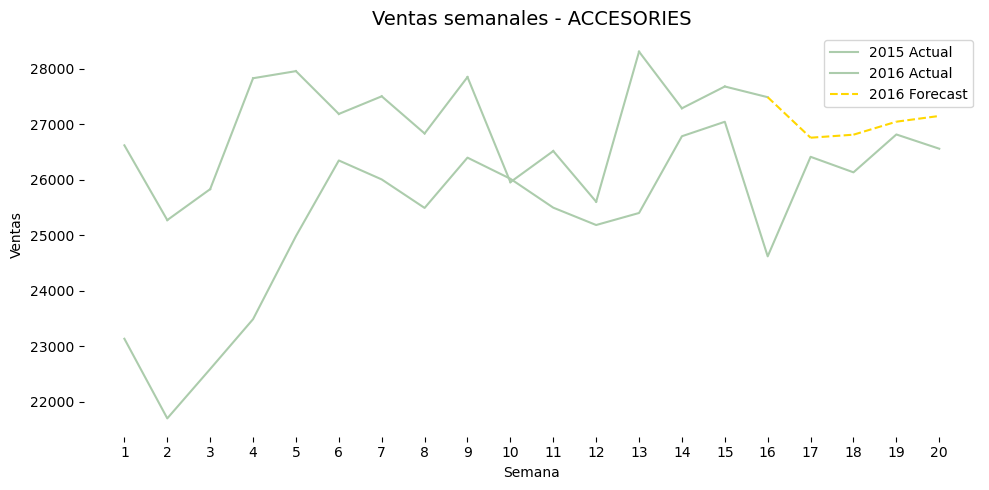

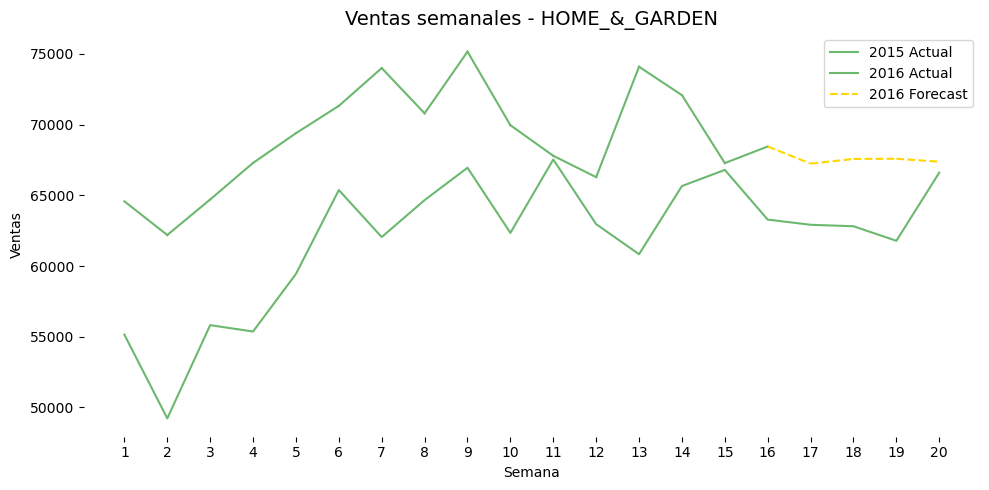

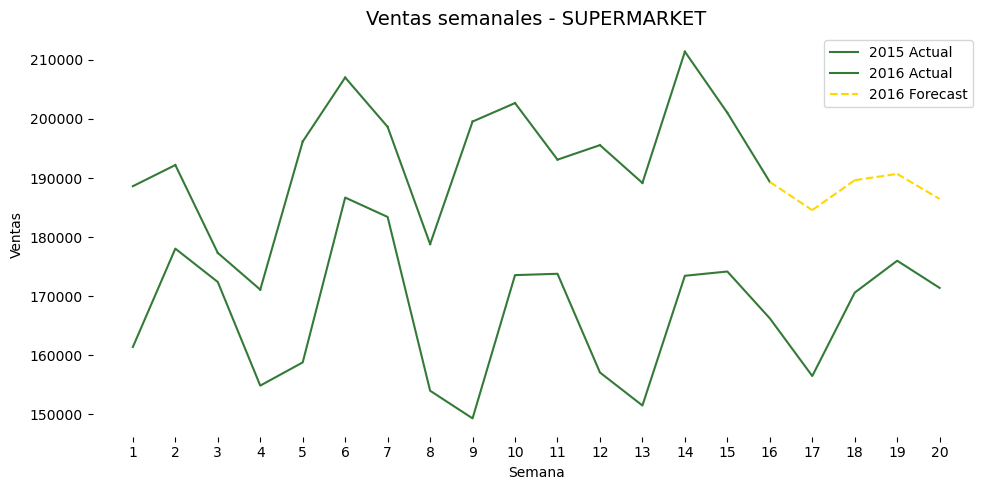

In [138]:
# Graficar por categoría
for cat in categories:
    data = df_sem20[df_sem20['category'] == cat].copy()
    color_actual = category_colors[cat]

    plt.figure(figsize=(10, 5))

    # Año 2015 - solo Actual
    data_2015 = data[(data['year'] == 2015) & (data['Qtype'] == 'Actual')].groupby('week')['Qsale'].sum().reset_index()
    plt.plot(data_2015['week'], data_2015['Qsale'], label='2015 Actual', color=color_actual, linestyle='-')

    # Año 2016 - Actual + Forecast unidos
    data_2016 = data[data['year'] == 2016].groupby(['week', 'Qtype'])['Qsale'].sum().reset_index()
    data_2016 = data_2016.sort_values('week')

    prev_point = None
    for _, row in data_2016.iterrows():
        if prev_point is not None:
            linestyle = '-' if row['Qtype'] == 'Actual' else '--'
            color_line = color_actual if row['Qtype'] == 'Actual' else color_2016_forecast
            plt.plot([prev_point['week'], row['week']],
                     [prev_point['Qsale'], row['Qsale']],
                     color=color_line, linestyle=linestyle)
        prev_point = row

    # Leyenda personalizada
    legend_elements = [
        plt.Line2D([], [], color=color_actual, linestyle='-', label='2015 Actual'),
        plt.Line2D([], [], color=color_actual, linestyle='-', label='2016 Actual'),
        plt.Line2D([], [], color=color_2016_forecast, linestyle='--', label='2016 Forecast')
    ]
    plt.legend(handles=legend_elements)

    # Estética limpia
    plt.title(f"Ventas semanales - {cat}", fontsize=14)
    plt.xlabel("Semana")
    plt.ylabel("Ventas")
    plt.xticks(range(1, 21))
    plt.grid(False)

    # Quitar recuadro
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.show()




In [139]:
# Obtener clusters únicos (sin nulos)
unique_clusters = df_2015_2016['cluster'].dropna().unique()

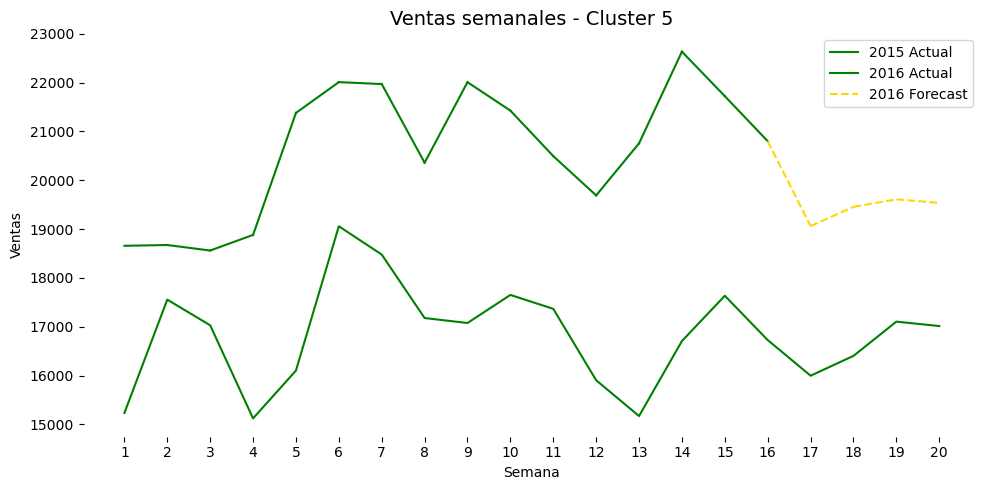

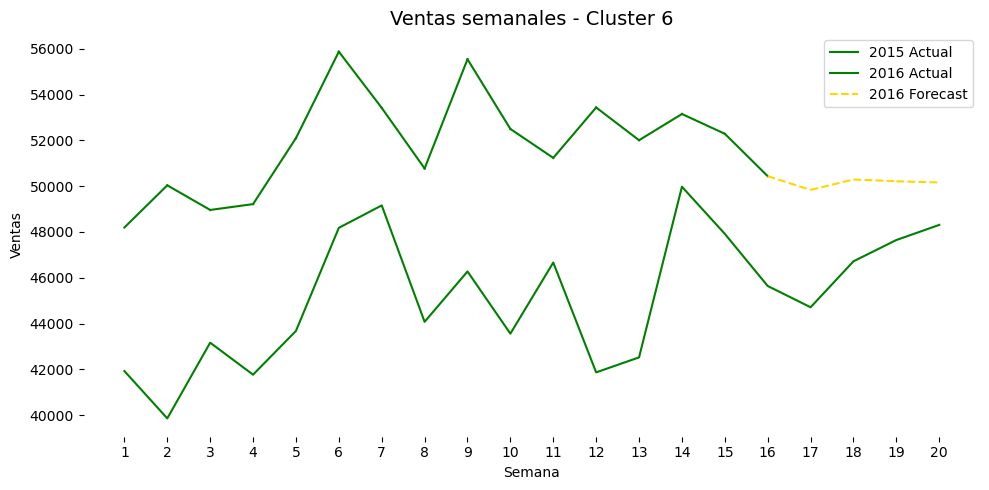

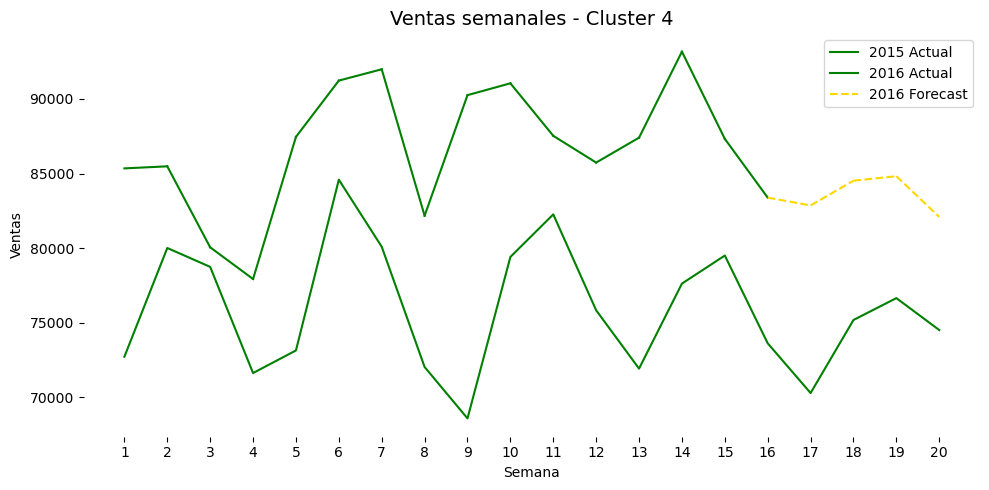

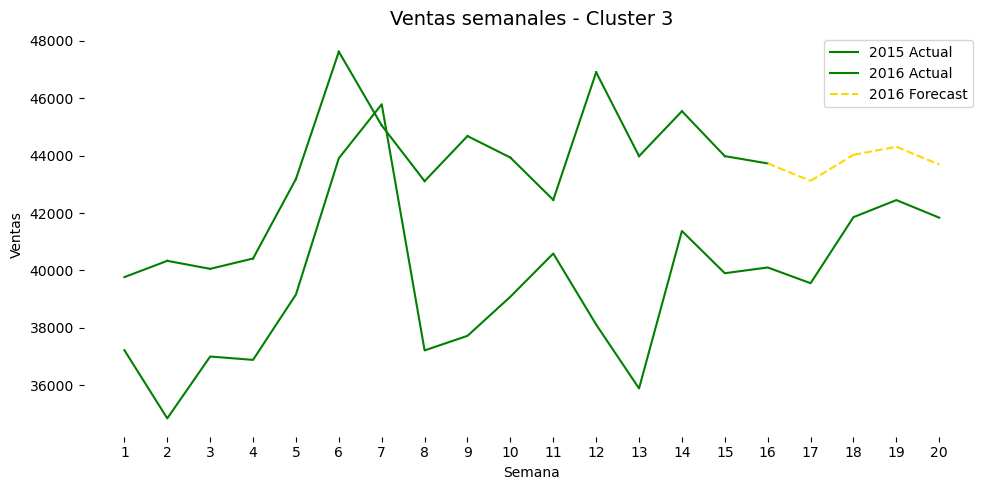

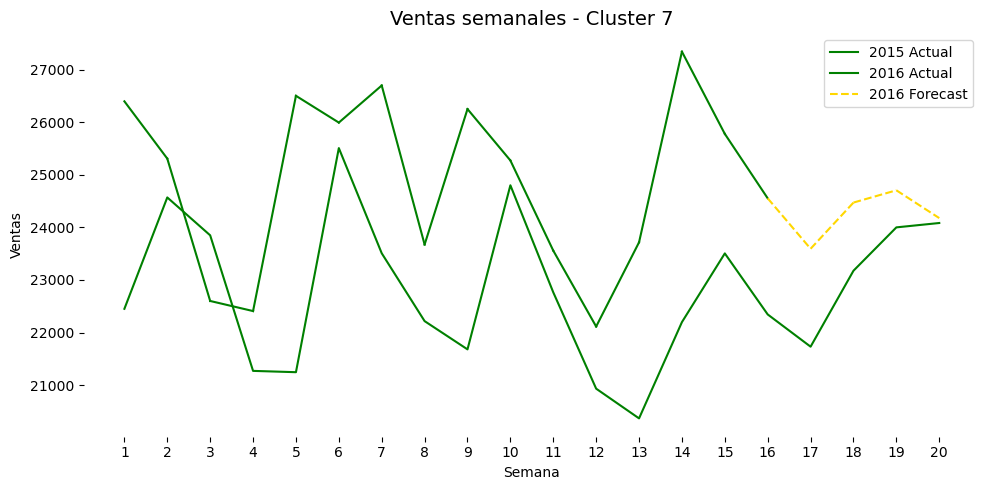

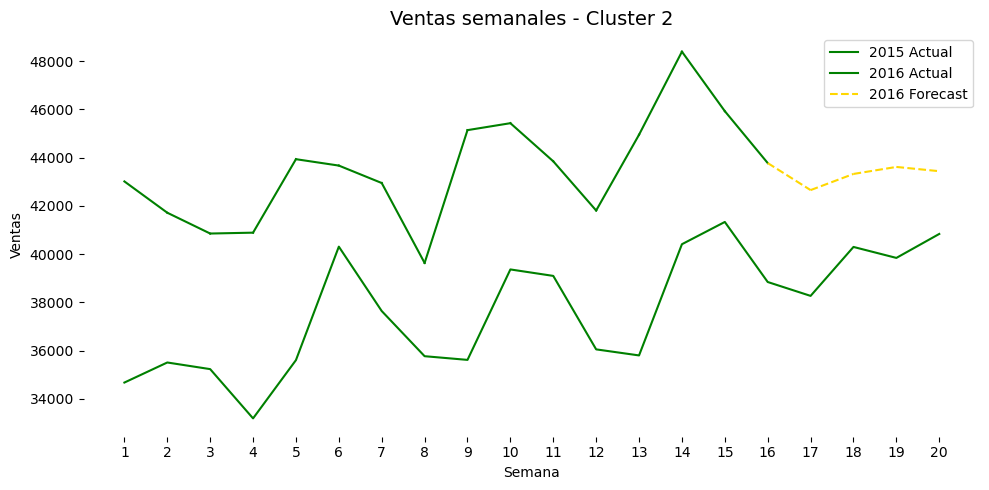

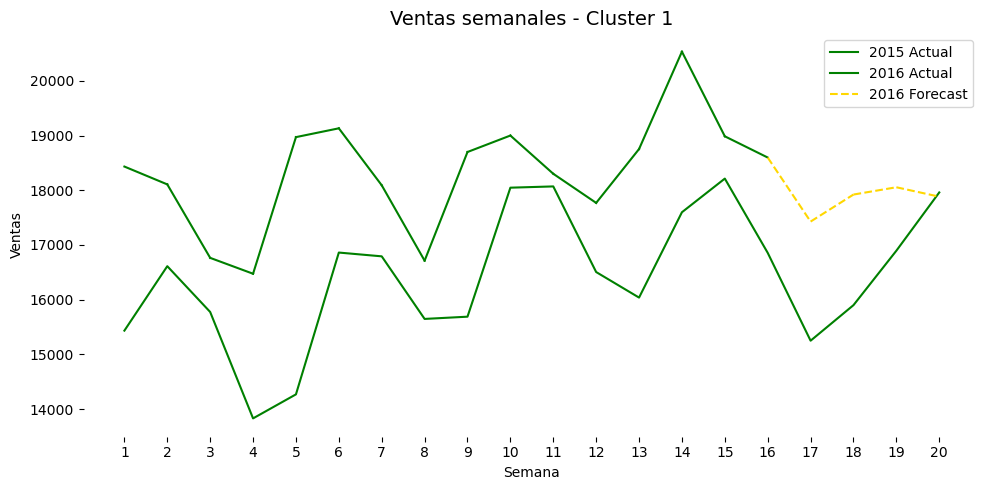

In [140]:
for clus in unique_clusters:
    data = df_sem20[df_sem20['cluster'] == clus].copy()

    plt.figure(figsize=(10, 5))

    # Año 2015 - solo Actual
    data_2015 = data[(data['year'] == 2015) & (data['Qtype'] == 'Actual')].groupby('week')['Qsale'].sum().reset_index()
    plt.plot(data_2015['week'], data_2015['Qsale'], label='2015 Actual', color='green', linestyle='-')

    # Año 2016 - Actual + Forecast unidos
    data_2016 = data[data['year'] == 2016].groupby(['week', 'Qtype'])['Qsale'].sum().reset_index()
    data_2016 = data_2016.sort_values('week')

    prev_point = None
    for _, row in data_2016.iterrows():
        if prev_point is not None:
            linestyle = '-' if row['Qtype'] == 'Actual' else '--'
            color_line = 'green' if row['Qtype'] == 'Actual' else color_2016_forecast
            plt.plot([prev_point['week'], row['week']],
                     [prev_point['Qsale'], row['Qsale']],
                     color=color_line, linestyle=linestyle)
        prev_point = row

    # Leyenda personalizada
    legend_elements = [
        plt.Line2D([], [], color='green', linestyle='-', label='2015 Actual'),
        plt.Line2D([], [], color='green', linestyle='-', label='2016 Actual'),
        plt.Line2D([], [], color=color_2016_forecast, linestyle='--', label='2016 Forecast')
    ]
    plt.legend(handles=legend_elements)

    # Estética limpia
    plt.title(f"Ventas semanales - Cluster {clus}", fontsize=14)
    plt.xlabel("Semana")
    plt.ylabel("Ventas")
    plt.xticks(range(1, 21))
    plt.grid(False)

    # Quitar recuadro
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.show()

In [141]:
# Función para aclarar colores
def lighten_color(color, factor=0.6):
    import matplotlib.colors as mc
    c = mc.to_rgb(color)
    return tuple(1 - (1 - x) * factor for x in c)


mayo_color = '#f4c542'  # amarillo predicción

# Filtrado
df_filtered = df_final_wpred[
    df_final_wpred['month'].isin([1, 2, 3, 4, 5]) &
    df_final_wpred['year'].isin([2015, 2016])
]

# Agrupación
ventas = df_filtered.groupby(['category', 'year', 'month', 'Qtype'])['Qsale'].sum().reset_index()
categories = ventas['category'].unique()

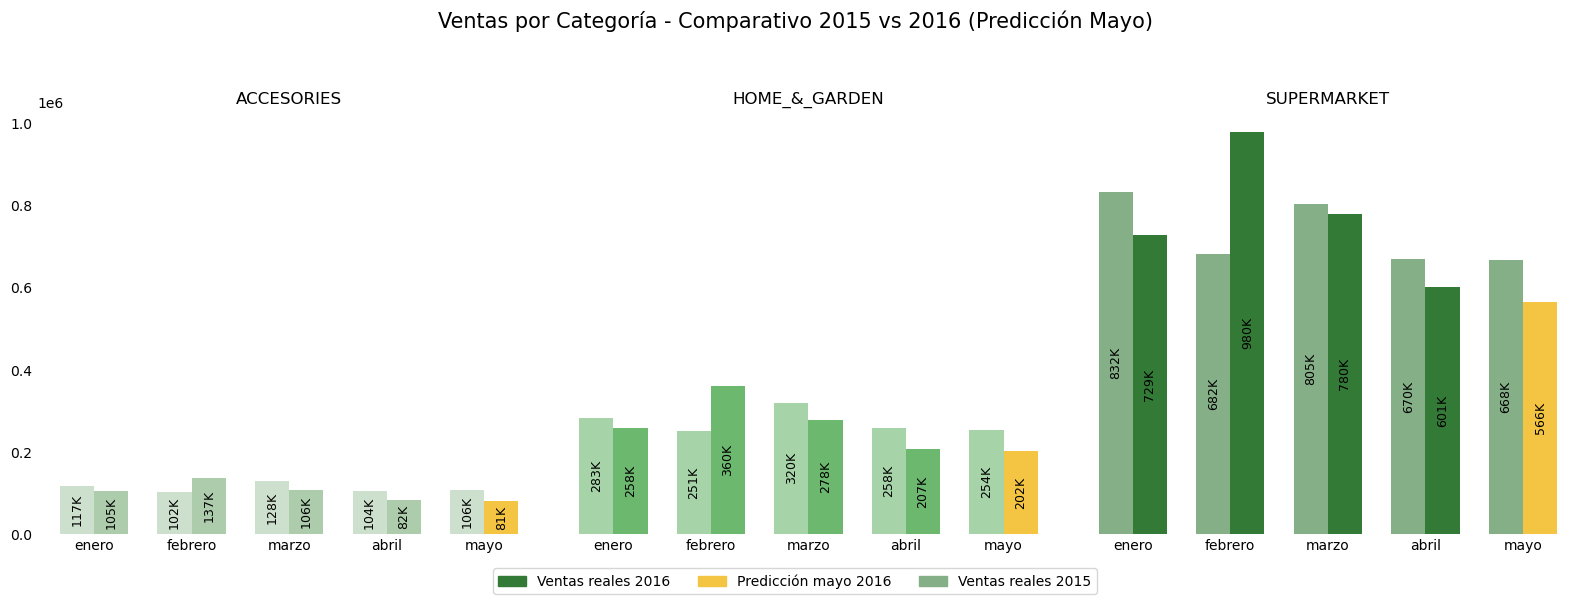

In [142]:
# Crear gráfico
fig, axes = plt.subplots(1, len(categories), figsize=(16, 6), sharey=True)
meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo']
bar_width = 0.35

for idx, cat in enumerate(categories):
    ax = axes[idx]
    base_color = category_colors[cat]
    light_color = lighten_color(base_color)

    data_cat = ventas[ventas['category'] == cat]
    data_2015 = data_cat[(data_cat['year'] == 2015) & (data_cat['Qtype'] == 'Actual')]
    data_2016 = data_cat[data_cat['year'] == 2016]

    # Diccionarios de ventas
    ventas_2015 = dict(zip(data_2015['month'], data_2015['Qsale']))
    ventas_2016 = {}

    for _, row in data_2016.iterrows():
        mes = row['month']
        tipo = row['Qtype']
        if mes == 5 and tipo == 'Forecast':
            ventas_2016[mes] = row['Qsale']
        elif mes < 5 and tipo == 'Actual':
            ventas_2016[mes] = row['Qsale']

    vals_2015 = [ventas_2015.get(i + 1, 0) for i in range(5)]
    vals_2016 = [ventas_2016.get(i + 1, 0) for i in range(5)]

    x = range(5)

    # Colores 2016 (amarillo para mayo)
    colores_2016 = [base_color]*4 + [mayo_color]

    # Barras
    ax.bar([i - bar_width/2 for i in x], vals_2015, width=bar_width, color=light_color)
    ax.bar([i + bar_width/2 for i in x], vals_2016, width=bar_width, color=colores_2016)

    # Etiquetas internas rotadas
    for i in range(5):
        if vals_2015[i] > 0:
            ax.text(i - bar_width/2, vals_2015[i]/2, f"{int(vals_2015[i]/1000)}K",
                    ha='center', va='center', fontsize=9, color='black', rotation=90)

        if vals_2016[i] > 0:
            ax.text(i + bar_width/2, vals_2016[i]/2, f"{int(vals_2016[i]/1000)}K",
                    ha='center', va='center', fontsize=9, color='black', rotation=90)

    # Estética
    ax.set_title(cat, fontsize=12, color='black')  # ahora en negro
    ax.set_xticks(x)
    ax.set_xticklabels(meses)
    ax.tick_params(axis='y', labelsize=10)

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)

    ax.tick_params(axis='y', length=0)
    ax.tick_params(axis='x', length=0)

# Leyenda personalizada
legend_patches = [
    mpatches.Patch(color=base_color, label='Ventas reales 2016'),
    mpatches.Patch(color=mayo_color, label='Predicción mayo 2016'),
    mpatches.Patch(color=light_color, label='Ventas reales 2015'),
]
fig.legend(handles=legend_patches, loc='lower center', ncol=3, fontsize=10)

fig.suptitle('Ventas por Categoría - Comparativo 2015 vs 2016 (Predicción Mayo)', fontsize=15)
fig.tight_layout(rect=[0, 0.05, 1, 0.93])  # espacio para la leyenda abajo
plt.show()

In [143]:
# Filtrado: solo mayo y años 2015 y 2016
df_mayo = df_final_wpred[
    (df_final_wpred['month'] == 5) &
    (df_final_wpred['year'].isin([2015, 2016]))
]


# Agrupar por tienda, año, tipo y ciudad
ventas = df_mayo.groupby(['store', 'year', 'Qtype', 'city'])['Qsale'].sum().reset_index()

stores = ventas['store'].unique()
# Crear DataFrame de tiendas con su ciudad (solo una fila por tienda)
stores_cities = ventas[['store', 'city']].drop_duplicates()

# Ordenar por ciudad, luego obtener la lista de tiendas
stores_ordenados = stores_cities.sort_values('city')['store'].values

In [144]:
bar_width = 0.15
espacio_entre_tiendas = 1.0

# Obtener lista de ciudades únicas
ciudades = ventas['city'].unique()

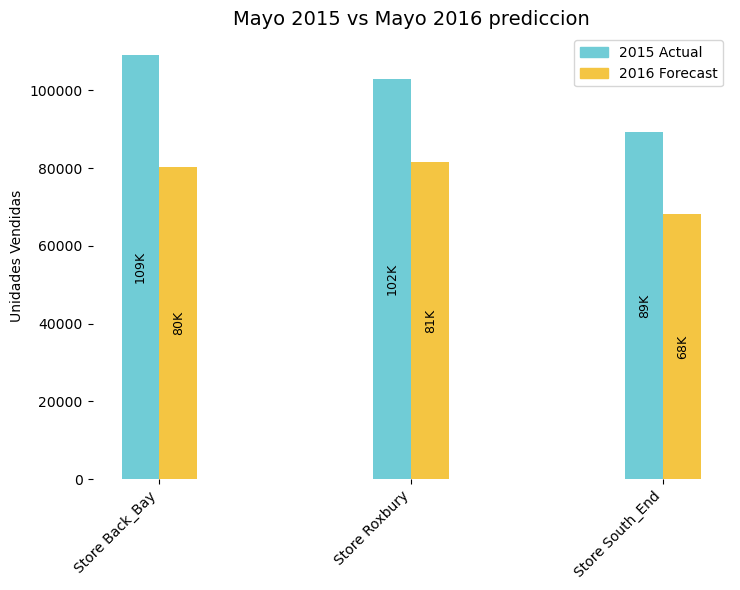

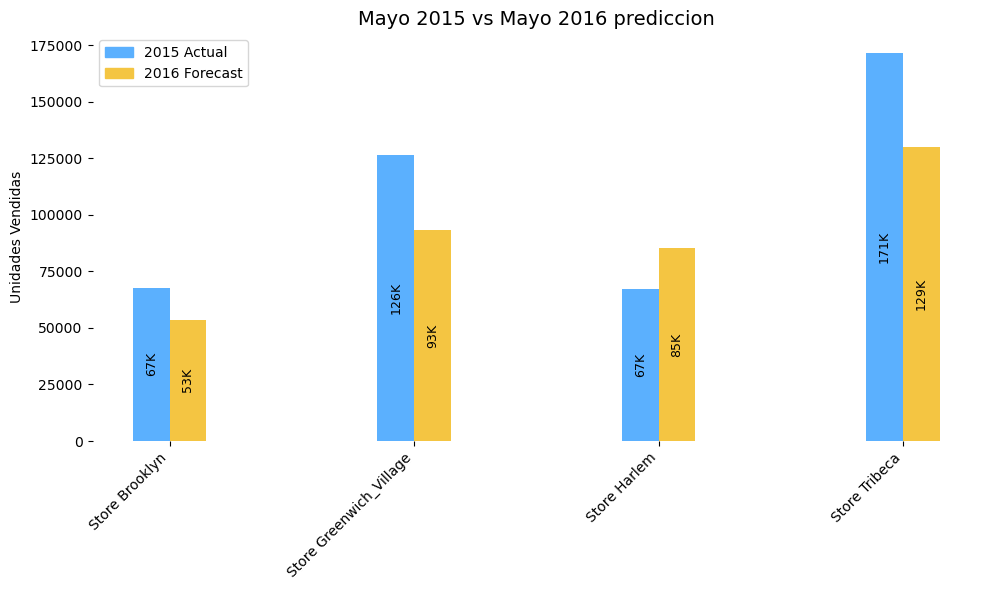

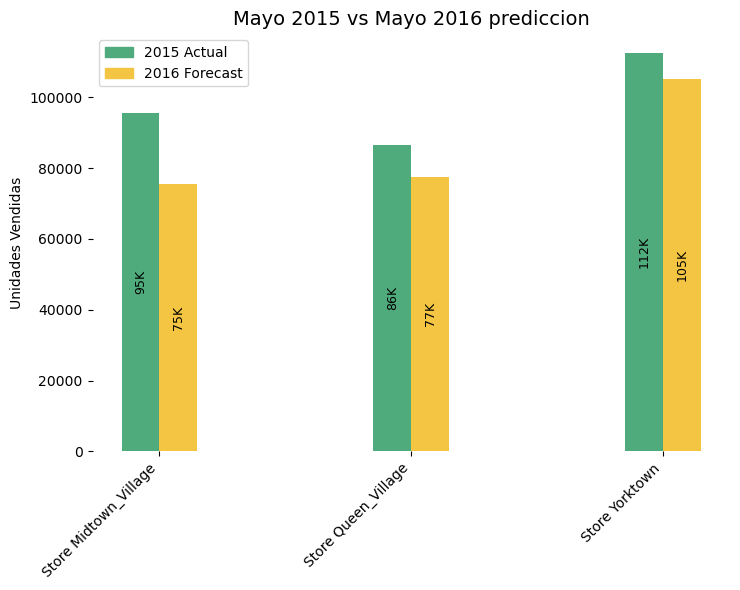

In [145]:
for ciudad in ciudades:
    df_ciudad = ventas[ventas['city'] == ciudad]
    tiendas_ciudad = df_ciudad['store'].unique()
    
    fig, ax = plt.subplots(figsize=(2.5 * len(tiendas_ciudad), 6))
    base_color = city_colors.get(ciudad, '#999999')
    
    posiciones = np.arange(len(tiendas_ciudad)) * espacio_entre_tiendas
    etiquetas = []
    
    for i, tienda in enumerate(tiendas_ciudad):
        data_store = df_ciudad[df_ciudad['store'] == tienda]

        # Ventas 2015
        q_2015 = data_store[(data_store['year'] == 2015) & (data_store['Qtype'] == 'Actual')]['Qsale'].sum()
        
        # Ventas 2016
        data_2016 = data_store[data_store['year'] == 2016]
        q_2016 = data_2016['Qsale'].sum()
        is_forecast = data_2016['Qtype'].iloc[0] == 'Forecast' if not data_2016.empty else False

        # Posiciones desplazadas
        x_2015 = posiciones[i] - bar_width / 2
        x_2016 = posiciones[i] + bar_width / 2

        # Graficar
        ax.bar(x_2015, q_2015, width=bar_width, color=base_color)
        ax.bar(x_2016, q_2016, width=bar_width, color=mayo_color if is_forecast else base_color)

        # Texto
        if q_2015 > 0:
            ax.text(x_2015, q_2015 / 2, f"{int(q_2015 / 1000)}K", ha='center', va='center', fontsize=9, rotation=90)
        if q_2016 > 0:
            ax.text(x_2016, q_2016 / 2, f"{int(q_2016 / 1000)}K", ha='center', va='center', fontsize=9, rotation=90)

        etiquetas.append(f"Store {tienda}")

    # Eje X
    ax.set_xticks(posiciones)
    ax.set_xticklabels(etiquetas, rotation=45, ha='right', fontsize=10)

    # Eje Y
    ax.tick_params(axis='y', labelsize=10)
    ax.set_ylabel('Unidades Vendidas')

    # Eliminar todos los recuadros
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_title(f"Mayo 2015 vs Mayo 2016 prediccion", fontsize=14)

    # Leyenda
    legend_patches = [
        mpatches.Patch(color=base_color, label='2015 Actual'),
        mpatches.Patch(color=mayo_color, label='2016 Forecast'),
    ]
    ax.legend(handles=legend_patches, fontsize=10)

    fig.tight_layout()
    plt.show()
